<a href="https://colab.research.google.com/github/shagufta24/Sales-TimeSeries-Forecasting/blob/main/Store_Sales_Time_Series_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from scipy.stats import ttest_ind
import statsmodels.api as sm
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, train_test_split, TimeSeriesSplit
from sklearn.metrics import make_scorer, mean_squared_log_error, mean_squared_error, mean_absolute_error
import xgboost as xgb
import lightgbm as lgb
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.filters.hp_filter import hpfilter
from sklearn.linear_model import LinearRegression
from scipy.signal import detrend, find_peaks
from statsmodels.tsa.stattools import acf, pacf
from sklearn.ensemble import RandomForestRegressor
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
COLORS = list(sns.color_palette())

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
base_path = "/content/drive/MyDrive/412-Project/data/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load datasets
data = pd.read_csv(base_path+'train.csv', parse_dates=['date'])
store = pd.read_csv(base_path+'stores.csv')
oil = pd.read_csv(base_path+"oil.csv", parse_dates=["date"]).rename(columns={"dcoilwtico": "oil"})
holiday = pd.read_csv(base_path+'holidays_events.csv', parse_dates=['date'])
transaction = pd.read_csv(base_path+'transactions.csv', parse_dates=['date'])

##Basic Information

In [ ]:
def cprint(title, *args):
    print(
        "="*len(title), title, "="*len(title),
        *args,
        sep="\n",
    )

num_family = data.family.nunique()
num_store = data.store_nbr.nunique()
num_ts = data.groupby(["store_nbr", "family"]).ngroups
data_start = data.date.min().date()
data_end = data.date.max().date()
num_data_date = data.date.nunique()
data_len = (data_end - data_start).days + 1

cprint(
    "Basic information of data",
    f"Number of family types      : {num_family}",
    f"Number of stores            : {num_store}",
    f"Number of store-family pairs: {num_family * num_store}",
    f"Number of target series     : {num_ts}",
    "",
    f"Number of unique train dates: {num_data_date}",
    f"Train date range            : {data_len} days from {data_start} to {data_end}"
)

Basic information of data
Number of family types      : 33
Number of stores            : 54
Number of store-family pairs: 1782
Number of target series     : 1782

Number of unique train dates: 1684
Train date range            : 1688 days from 2013-01-01 to 2017-08-15


In [ ]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB
None


In [ ]:
print(store.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB
None


In [ ]:
print(oil.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1218 non-null   datetime64[ns]
 1   oil     1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB
None


In [ ]:
print(holiday.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB
None


In [ ]:
print(transaction.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.9 MB
None


##Hypothesis Tests for Feature Importance

Test to see if Holidays affect sales

In [ ]:
# Merge traindf with holiday_df on 'date' to identify holiday sales
data_holiday_df = data.merge(holiday[['date']], on='date', how='left', indicator=True)

# Create a binary 'is_holiday' column (1 if holiday, 0 if not)
data_holiday_df['is_holiday'] = (data_holiday_df['_merge'] == 'both').astype(int)

# Separate sales on holidays and non-holidays
holiday_sales = data_holiday_df[data_holiday_df['is_holiday'] == 1]['sales']
non_holiday_sales = data_holiday_df[data_holiday_df['is_holiday'] == 0]['sales']

# Perform t-test
t_stat, p_value = ttest_ind(holiday_sales, non_holiday_sales)

# Print results
# print("T-statistic:", t_stat)
# print("P-value:", p_value)

# Interpretation based on p-value
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: Holidays do affect sales.")
else:
    print("Fail to reject the null hypothesis: No significant effect of holidays on sales.")

Reject the null hypothesis: Holidays do affect sales.


Test to see if Oil Prices affect Sales

In [ ]:
# Merge traindf with oil_df on 'date' to get oil prices aligned with sales data
data_oil_df = data.merge(oil, on='date', how='left')

# Drop any rows where oil prices are NaN (if there's missing data for some dates)
data_oil_df = data_oil_df.dropna(subset=['oil'])

# Prepare the data for regression
X = data_oil_df['oil']          # Independent variable: oil prices
y = data_oil_df['sales']        # Dependent variable: sales

# Add a constant to the independent variable for regression analysis
X = sm.add_constant(X)

# Run the linear regression
model = sm.OLS(y, X).fit()

# Print the summary to view the coefficient, t-statistic, and p-value
# print(model.summary())

# Interpretation based on the p-value for the oil coefficient
alpha = 0.05
oil_p_value = model.pvalues['oil']
if oil_p_value < alpha:
    print("Reject the null hypothesis: Oil prices do affect sales.")
else:
    print("Fail to reject the null hypothesis: No significant effect of oil prices on sales.")

Reject the null hypothesis: Oil prices do affect sales.


##Data Merging and Preprocessing

Merging train and test with store data

In [ ]:
data = pd.merge(data, store, on='store_nbr', how='left')

Merging train and test with oil Data.
Fill any missing values using backward fill - fill in the missing data point with the next value.

In [ ]:
data = pd.merge(data, oil, on='date', how='left')
data['oil'] = data['oil'].bfill()

Transferred holidays are treated like regular work days, so we can filter them out of holiday dataset

In [ ]:
holiday = holiday[holiday['transferred'] == False]

For holidays, the national holidays can be merged with all stores. The regional holidays are merged only with stores in the same state. The local holidays are merged only with stores in the same city.

Combining this data, we can add a new column called 'is_holiday' to indicate whether it is a holiday or not in each row.

In [ ]:
# National holidays: Apply to all stores
national_holidays = holiday[holiday['locale'] == 'National']
national_holidays = national_holidays[['date', 'description']].drop_duplicates()
national_holidays['is_national_holiday'] = 1
store['key'] = 1
national_holidays['key'] = 1
national_holidays = pd.merge(national_holidays, store[['store_nbr', 'key']], on='key').drop('key', axis=1)

# Regional holidays: Apply to stores in the same state
regional_holidays = holiday[holiday['locale'] == 'Regional']
regional_holidays = pd.merge(
    regional_holidays[['date', 'description', 'locale_name']],
    store[['store_nbr', 'state']],
    left_on='locale_name', right_on='state',
    how='inner'
)
regional_holidays['is_regional_holiday'] = 1

# Local holidays: Apply to stores in the same city
local_holidays = holiday[holiday['locale'] == 'Local']
local_holidays = pd.merge(
    local_holidays[['date', 'description', 'locale_name']],
    store[['store_nbr', 'city']],
    left_on='locale_name', right_on='city',
    how='inner'
)
local_holidays['is_local_holiday'] = 1

# Concatenate all holiday types into a single DataFrame
holidays_per_store = pd.concat([national_holidays, regional_holidays, local_holidays], ignore_index=True)

# Keep only relevant columns
holidays_per_store = holidays_per_store[['date', 'store_nbr', 'is_national_holiday', 'is_regional_holiday', 'is_local_holiday']].drop_duplicates()

# Merge with train data and fill missing values
data = pd.merge(data, holidays_per_store, on=['date', 'store_nbr'], how='left')
data['is_national_holiday'] = data['is_national_holiday'].fillna(0)
data['is_regional_holiday'] = data['is_regional_holiday'].fillna(0)
data['is_local_holiday'] = data['is_local_holiday'].fillna(0)

In [ ]:
work_days = holiday[holiday.type.eq("Work Day")]
work_days = work_days[["date", "type"]].rename(
    columns={"type": "work_day"}
).reset_index(drop=True)
work_days.work_day = work_days.work_day.notna().astype(int)

Merging train and test with transactions data. Fill any missing values with 0, which is equivalent to the transaction not happening.

In [ ]:
data = pd.merge(data, transaction, on=['date', 'store_nbr'], how='left')
data['transactions'] = data['transactions'].fillna(0)

##Feature Engineering

**Date-based features:**
For capturing time-based patterns, seasonality, and cyclical behavior in the data. These can help the model understand temporal trends, which is helpful if there are long-term trends that the model should apply to the test data, such as increasing demand during certain months or a declining trend across years.

In [ ]:
def create_date_features(df: pd.DataFrame) -> pd.DataFrame:
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekofyear'] = df['date'].dt.isocalendar().week.astype('int64')
    df['quarter'] = df['date'].dt.quarter
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
    return df

data = create_date_features(data)

**Lag features**: Using lags of 1, 7, 14 and 28 to capture daily, weekly, bi-weekly, and monthly patterns in the data. Using a combination of short-term and longer-term lags gives the model access to a range of information about how the target variable changes over time.

In [ ]:
for lag in [1, 7, 14, 28]:
    data[f'lag_{lag}'] = data.groupby(['store_nbr', 'family'])['sales'].shift(lag)

**Lagged Oil Prices effect on Sales**

In [ ]:
for lag in [1, 7, 14, 28]:
    data[f'oil_lag_{lag}'] = data.groupby(['store_nbr', 'family'])['oil'].shift(lag)

**Lagged Holidays**

In [ ]:
for lag in [1, 7, 14, 28]:
    data[f'is_national_holiday_lag_{lag}'] = data.groupby(['store_nbr', 'family'])['is_national_holiday'].shift(lag)

**Rolling features**: They smooth out daily fluctuations and capture longer-term trends.

In [ ]:
for window in [7, 14, 28]:
    data[f'rolling_mean_{window}'] = data.groupby(['store_nbr', 'family'])['sales'].shift(1).rolling(window=window).mean()

Deal with Nan values

In [ ]:
# List of features
features = [f'lag_{lag}' for lag in [1, 7, 14, 28]] + [f'oil_lag_{lag}' for lag in [1, 7, 14, 28]] + [f'is_national_holiday_lag_{lag}' for lag in [1, 7, 14, 28]] + [f'rolling_mean_{window}' for window in [7, 14, 28]]
# Impute remaining NaN values with group-specific median
for feature in features:
    data[feature] = data.groupby(['store_nbr', 'family'])[feature].transform(lambda x: x.fillna(x.median()))

Make sure there are no missing values

In [ ]:
columns_list = data.columns.tolist()
print("Missing values:")
print(data[columns_list].isnull().sum())

Missing values:
id                            0
date                          0
store_nbr                     0
family                        0
sales                         0
onpromotion                   0
city                          0
state                         0
type                          0
cluster                       0
oil                           0
is_national_holiday           0
is_regional_holiday           0
is_local_holiday              0
transactions                  0
year                          0
month                         0
day                           0
dayofweek                     0
weekofyear                    0
quarter                       0
is_weekend                    0
lag_1                         0
lag_7                         0
lag_14                        0
lag_28                        0
oil_lag_1                     0
oil_lag_7                     0
oil_lag_14                    0
oil_lag_28                    0
is_national_holiday_lag_

##Trend and Seasonality

**Simple and Exponential Moving Average**

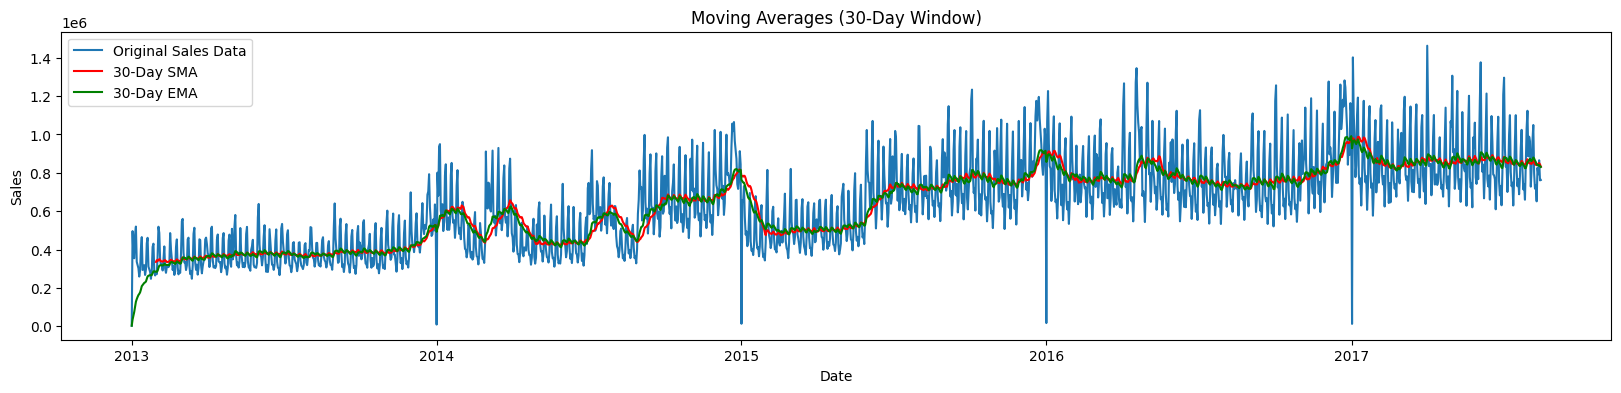

In [ ]:
sales_data = data.groupby('date')['sales'].sum()
sma = sales_data.rolling(window=30).mean()
ema = sales_data.ewm(span=30, adjust=False).mean()

plt.figure(figsize=(20, 4))
plt.plot(sales_data, label='Original Sales Data')
plt.plot(sma, label='30-Day SMA', color='red')
plt.plot(ema, label='30-Day EMA', color='green')
plt.title('Moving Averages (30-Day Window)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

**Additive Decomposition**

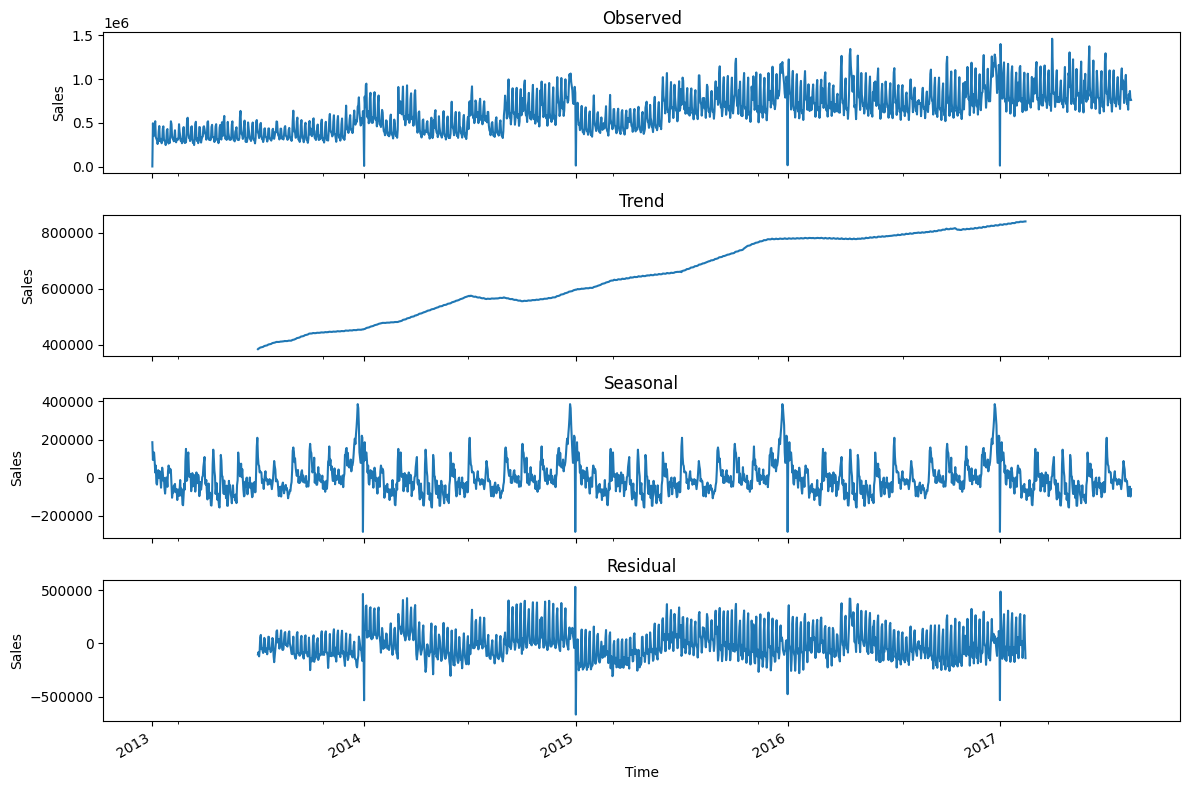

In [ ]:
decomposition = seasonal_decompose(sales_data, model='additive', period=365)

fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

# Observed Plot
decomposition.observed.plot(ax=axes[0], title='Observed')
axes[0].set_ylabel('Sales')

# Trend Plot
decomposition.trend.plot(ax=axes[1], title='Trend')
axes[1].set_ylabel('Sales')

# Seasonal Plot
decomposition.seasonal.plot(ax=axes[2], title='Seasonal')
axes[2].set_ylabel('Sales')

# Residual Plot
decomposition.resid.plot(ax=axes[3], title='Residual')
axes[3].set_ylabel('Sales')
axes[3].set_xlabel('Time')

plt.tight_layout()
plt.show()

Adding Additive Decomposition Seasonality and Trend as Features

In [ ]:
# 365 days period
decomposition_365 = seasonal_decompose(data["sales"], model='additive', period=365)
data['trend_365'] = decomposition_365.trend
data['seasonal_365'] = decomposition_365.seasonal

# 7 days period
decomposition_7 = seasonal_decompose(data["sales"], model="additive", period=7)
data['trend_7'] = decomposition_7.trend
data['seasonal_7'] = decomposition_7.seasonal

# 28 days period
decomposition_28 = seasonal_decompose(data["sales"], model="additive", period=28)  # Adjust freq based on your seasonality
data['trend_28'] = decomposition_7.trend
data['seasonal_28'] = decomposition_7.seasonal

In [ ]:
# Handle missing values by interpolation
data['trend_365'] = data['trend_365'].interpolate(method='linear')
data['seasonal_365'] = data['seasonal_365'].interpolate(method='linear')

data['trend_7'] = data['trend_7'].interpolate(method='linear')
data['seasonal_7'] = data['seasonal_7'].interpolate(method='linear')

data['trend_28'] = data['trend_28'].interpolate(method='linear')
data['seasonal_28'] = data['seasonal_28'].interpolate(method='linear')

# Ffill/Bfill for remaining values
data['trend_365'] = data['trend_365'].fillna(method='ffill').fillna(method='bfill')
data['seasonal_365'] = data['seasonal_365'].fillna(method='ffill').fillna(method='bfill')

data['trend_7'] = data['trend_7'].fillna(method='ffill').fillna(method='bfill')
data['seasonal_7'] = data['seasonal_7'].fillna(method='ffill').fillna(method='bfill')

data['trend_28'] = data['trend_28'].fillna(method='ffill').fillna(method='bfill')
data['seasonal_28'] = data['seasonal_28'].fillna(method='ffill').fillna(method='bfill')

<ipython-input-29-edf499a7fe1c>:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['trend_365'] = data['trend_365'].fillna(method='ffill').fillna(method='bfill')
<ipython-input-29-edf499a7fe1c>:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['seasonal_365'] = data['seasonal_365'].fillna(method='ffill').fillna(method='bfill')
<ipython-input-29-edf499a7fe1c>:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['trend_7'] = data['trend_7'].fillna(method='ffill').fillna(method='bfill')
<ipython-input-29-edf499a7fe1c>:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['seasonal_7'] = data['seasonal_7'].fillna(method='ffill')

**Linear Regression Trend Line**

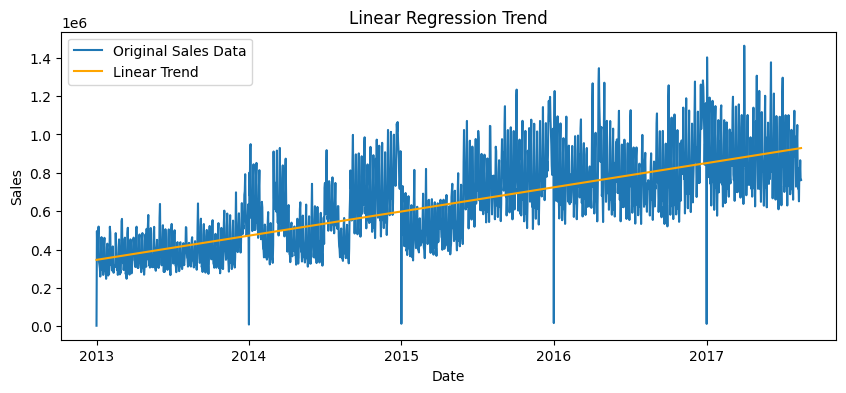

In [ ]:
X = np.arange(len(sales_data)).reshape(-1, 1)
y = sales_data.values
linear_model = LinearRegression().fit(X, y)
trend = linear_model.predict(X)

plt.figure(figsize=(10, 4))
plt.plot(sales_data, label='Original Sales Data')
plt.plot(sales_data.index, trend, label='Linear Trend', color='orange')
plt.title('Linear Regression Trend')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

**Exponential Smoothing**

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


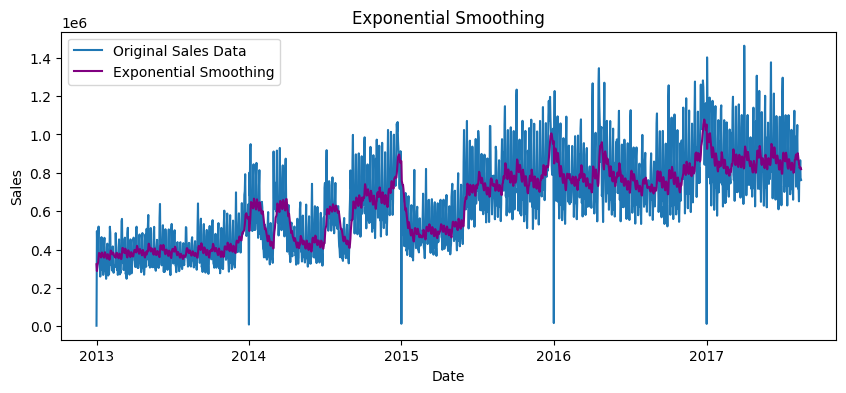

In [ ]:
exp_smooth = ExponentialSmoothing(sales_data, trend='add', seasonal=None).fit()
exp_smooth_trend = exp_smooth.fittedvalues

plt.figure(figsize=(10, 4))
plt.plot(sales_data, label='Original Sales Data')
plt.plot(exp_smooth_trend, label='Exponential Smoothing', color='purple')
plt.title('Exponential Smoothing')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

**Hodrick-Prescott Filter**

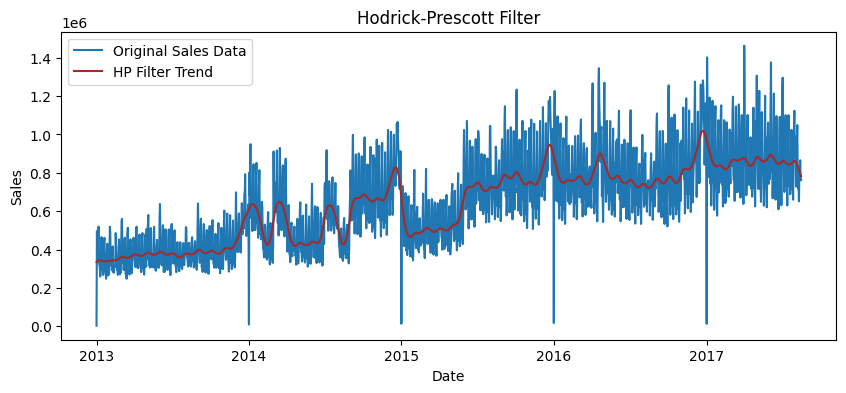

In [ ]:
cycle, trend_hp = hpfilter(sales_data, lamb=1600)

plt.figure(figsize=(10, 4))
plt.plot(sales_data, label='Original Sales Data')
plt.plot(trend_hp, label='HP Filter Trend', color='brown')
plt.title('Hodrick-Prescott Filter')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

**Seasonal-Trend Decomposition using LOESS (STL)**

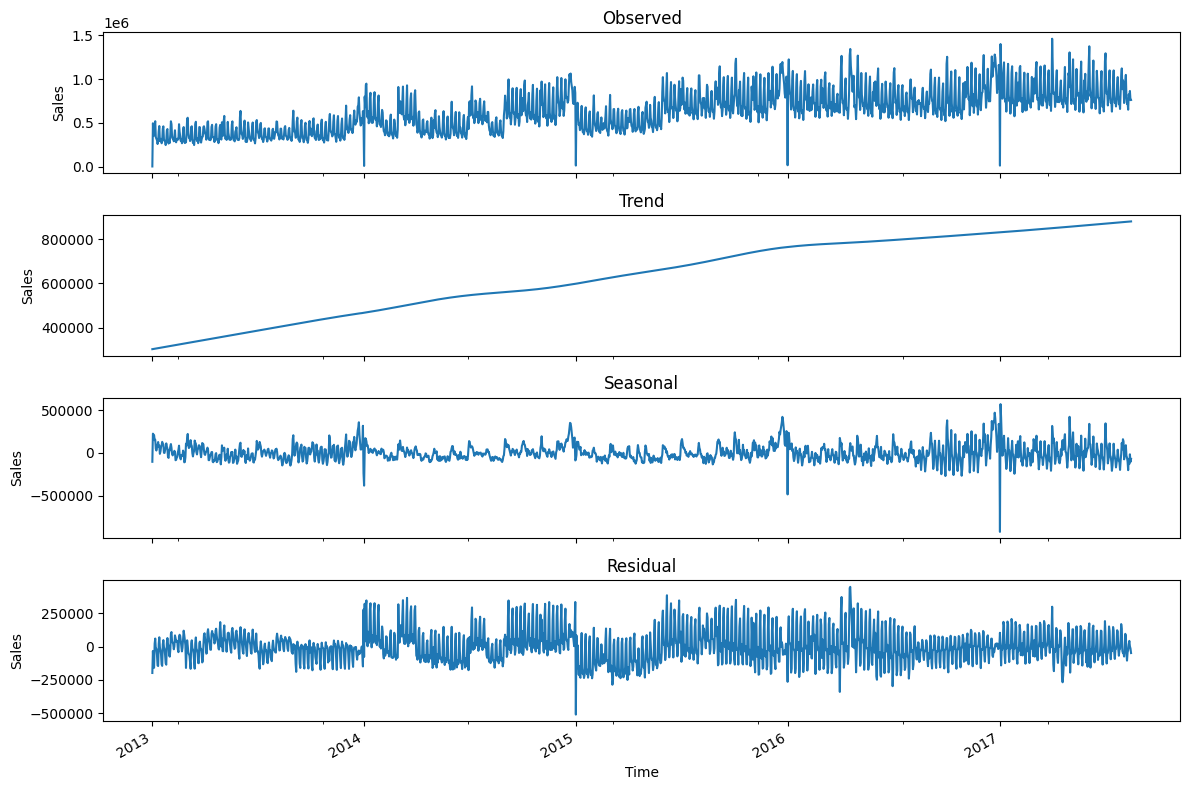

In [ ]:
stl = sm.tsa.STL(sales_data, period=365)
stl_decomposition = stl.fit()

fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

# Observed Plot
stl_decomposition.observed.plot(ax=axes[0], title='Observed')
axes[0].set_ylabel('Sales')

# Trend Plot
stl_decomposition.trend.plot(ax=axes[1], title='Trend')
axes[1].set_ylabel('Sales')

# Seasonal Plot
stl_decomposition.seasonal.plot(ax=axes[2], title='Seasonal')
axes[2].set_ylabel('Sales')

# Residual Plot
stl_decomposition.resid.plot(ax=axes[3], title='Residual')
axes[3].set_ylabel('Sales')
axes[3].set_xlabel('Time')

plt.tight_layout()
plt.show()

Adding STL Seasonality and Trend as Features

In [ ]:
# 365 days period
# stl_decomposition_365 = sm.tsa.STL(data["sales"], period=365).fit()
# data['stl_trend_365'] = stl_decomposition_365.trend
# data['stl_seasonal_365'] = stl_decomposition_365.seasonal

# # 7 days period
# stl_decomposition_7 = sm.tsa.STL(data["sales"], period=7).fit()
# data['stl_trend_7'] = stl_decomposition_7.trend
# data['stl_seasonal_7'] = stl_decomposition_7.seasonal

# # 28 days period
# stl_decomposition_28 = sm.tsa.STL(data["sales"], period=30).fit()
# data['stl_trend_28'] = stl_decomposition_28.trend
# data['stl_seasonal_28'] = stl_decomposition_28.seasonal

**Fourier Transform (Identify Cycles)**

Most Dominant Cycles:
Rank 1: Frequency = 0.00059, Amplitude = 165199836.07, Period = 1684.00 days
Rank 2: Frequency = 0.14311, Amplitude = 97733368.43, Period = 6.99 days
Rank 3: Frequency = 0.00178, Amplitude = 69516647.70, Period = 561.33 days
Rank 4: Frequency = 0.00119, Amplitude = 68352302.64, Period = 842.00 days
Rank 5: Frequency = 0.00238, Amplitude = 51494563.27, Period = 421.00 days
Rank 6: Frequency = 0.00416, Amplitude = 42851119.72, Period = 240.57 days
Rank 7: Frequency = 0.28622, Amplitude = 37055472.52, Period = 3.49 days
Rank 8: Frequency = 0.28682, Amplitude = 36269838.79, Period = 3.49 days
Rank 9: Frequency = 0.14371, Amplitude = 35768447.90, Period = 6.96 days
Rank 10: Frequency = 0.06591, Amplitude = 31179812.82, Period = 15.17 days


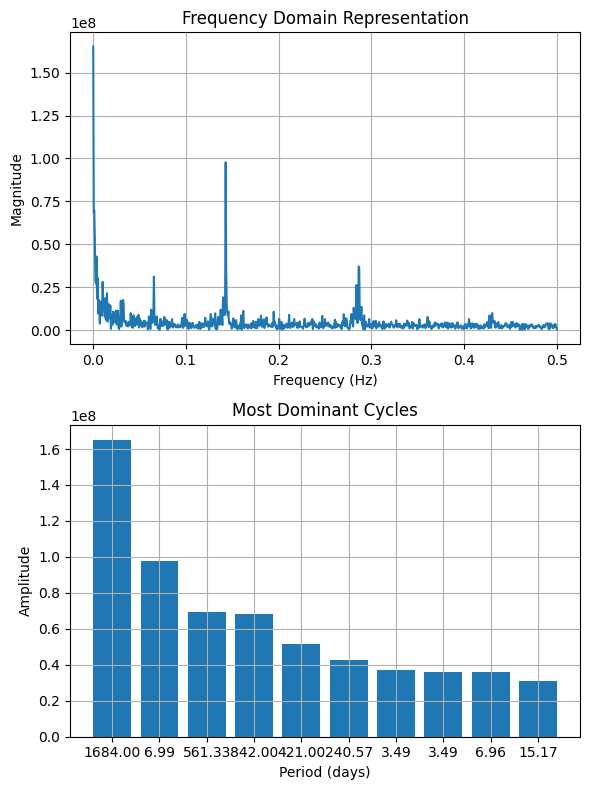

In [ ]:
# Apply transform
fft = np.fft.fft(sales_data.values)
frequencies = np.fft.fftfreq(len(fft))

# Consider only positive frequencies
positive_frequencies = frequencies[frequencies > 0]
fft_magnitude = np.abs(fft[frequencies > 0])

# Get the top frequencies with the highest amplitudes
top_indices = np.argsort(fft_magnitude)[-10:][::-1]  # Indices of top 10 amplitudes
top_frequencies = positive_frequencies[top_indices]
top_amplitudes = fft_magnitude[top_indices]

# Convert frequencies to periods
sampling_rate = 1  # Adjust based on your time unit (e.g., daily, monthly)
top_periods = 1 / top_frequencies

# Display the top 10 cycles
print("Most Dominant Cycles:")
for i, (freq, amp, period) in enumerate(zip(top_frequencies, top_amplitudes, top_periods)):
    print(f"Rank {i+1}: Frequency = {freq:.5f}, Amplitude = {amp:.2f}, Period = {period:.2f} days")

# Create a figure with two subplots
fig, axs = plt.subplots(2, 1, figsize=(6, 8))

# Frequency domain plot
axs[0].plot(positive_frequencies, fft_magnitude)
axs[0].set_title('Frequency Domain Representation')
axs[0].set_xlabel('Frequency (Hz)')
axs[0].set_ylabel('Magnitude')
axs[0].grid()

# Bar chart for top frequencies
axs[1].bar(range(0, 10), top_amplitudes, tick_label=[f"{p:.2f}" for p in top_periods])
axs[1].set_title('Most Dominant Cycles')
axs[1].set_xlabel('Period (days)')
axs[1].set_ylabel('Amplitude')
axs[1].grid()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

**Autocorrelation Function (ACF)**


<Figure size 1400x600 with 0 Axes>

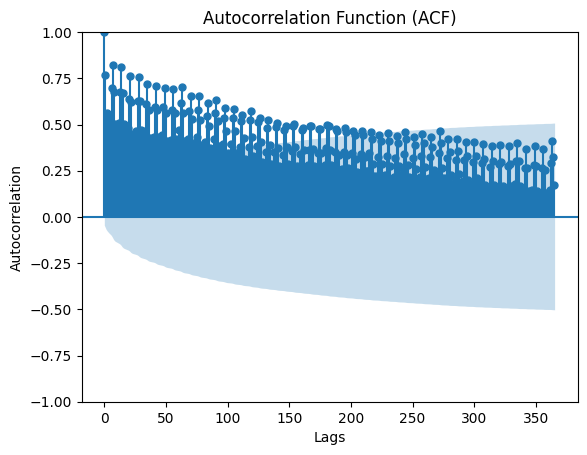

In [ ]:
plt.figure(figsize=(14, 6))
sm.graphics.tsa.plot_acf(sales_data, lags=365, alpha=0.05)
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

**Partial Autocorrelation Function (PACF)**

<Figure size 4000x2500 with 0 Axes>

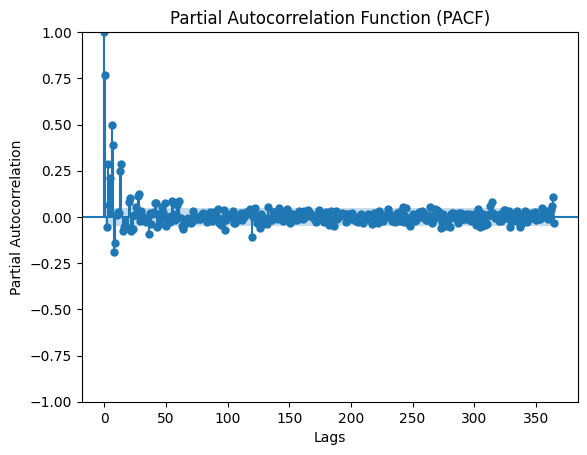

In [ ]:
plt.figure(figsize=(40, 25))
sm.graphics.tsa.plot_pacf(sales_data, lags=365, alpha=0.05, method='ywm')
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.show()

<ipython-input-38-7d772a5f566f>:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1,2,figsize=(10,3))


--------------
ACF lags summary
{7: 28, 14: 25, 1: 23, 28: 22, 21: 21, 63: 20, 35: 19, 49: 18, 56: 18, 42: 17, 6: 15, 8: 14, 2: 13, 5: 13, 13: 13, 70: 13, 3: 12, 4: 12, 15: 12, 91: 11, 20: 11, 9: 10, 77: 10, 22: 10, 27: 10, 29: 10, 84: 9, 34: 9, 48: 9, 55: 9, 62: 9, 10: 9, 11: 9, 12: 9, 16: 9, 17: 9, 18: 9, 19: 9, 41: 8, 43: 8, 57: 8, 36: 7, 50: 7, 23: 6, 98: 5, 119: 5, 24: 5, 25: 5, 26: 5, 64: 5, 69: 4, 105: 4, 112: 4, 76: 4, 30: 4, 31: 4, 32: 4, 33: 4, 37: 4, 38: 4, 39: 4, 40: 4, 44: 4, 45: 4, 46: 4, 47: 4, 51: 4, 52: 4, 53: 4, 54: 4, 58: 4, 59: 4, 60: 4, 61: 4, 65: 3, 66: 3, 67: 3, 68: 3, 71: 3, 78: 3, 83: 3, 72: 2, 73: 2, 74: 2, 75: 2, 79: 2, 80: 2, 81: 2, 82: 2, 85: 2, 86: 2, 87: 2, 88: 2, 89: 2, 90: 2, 92: 2, 96: 2, 97: 2, 99: 2, 103: 2, 104: 2, 106: 2, 110: 2, 111: 2, 113: 2, 117: 2, 118: 2, 120: 2, 124: 2, 125: 2, 126: 2, 127: 2, 132: 2, 133: 2, 139: 2, 140: 2, 146: 2, 147: 2, 363: 1, 364: 1, 365: 1, 107: 1, 108: 1, 114: 1, 93: 1, 131: 1, 134: 1, 138: 1, 153: 1, 154: 1}
ACF lag

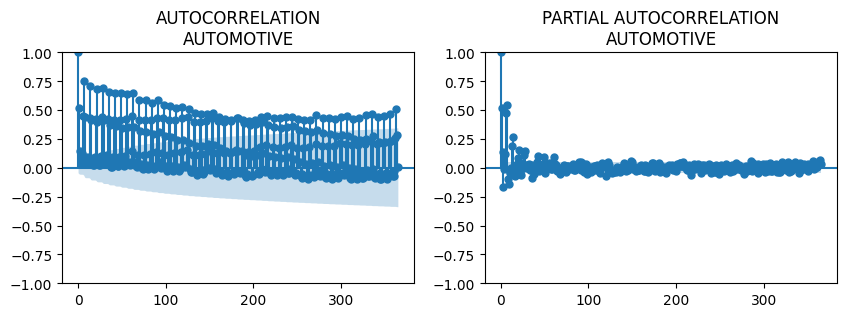

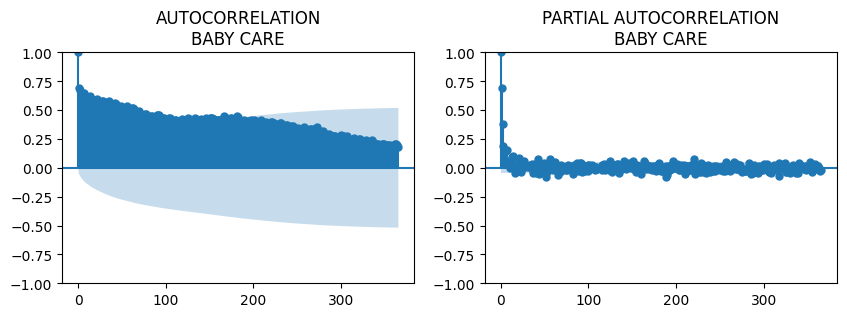

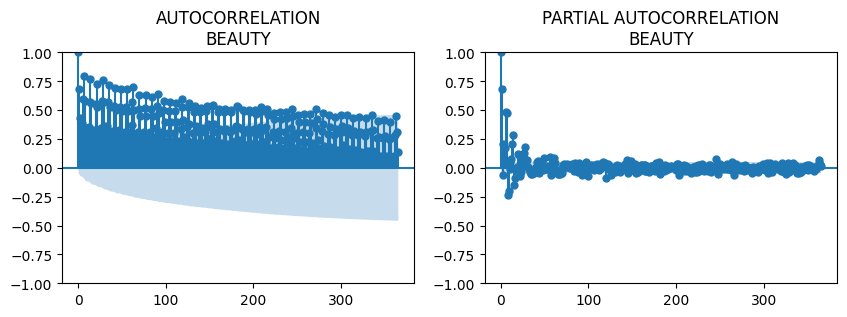

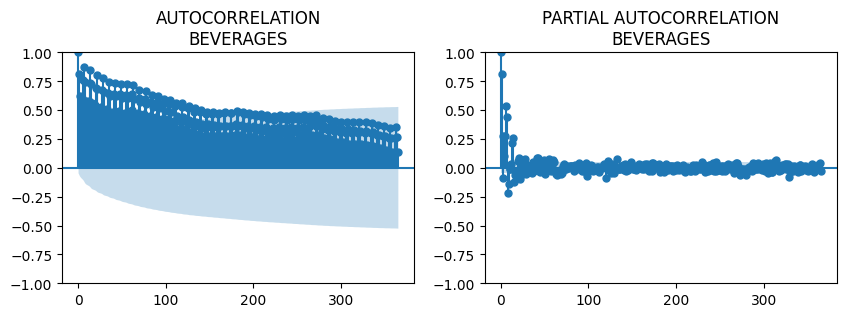

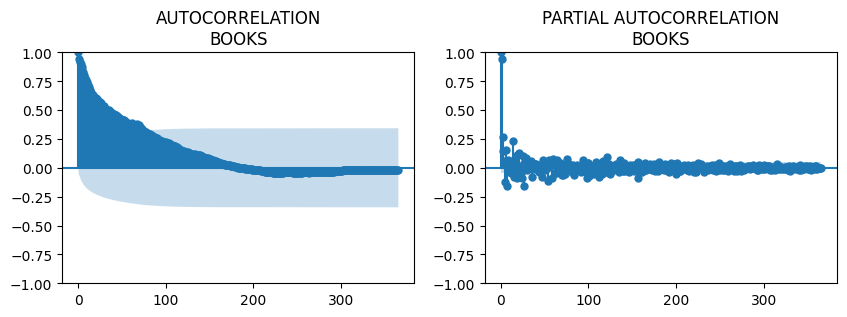

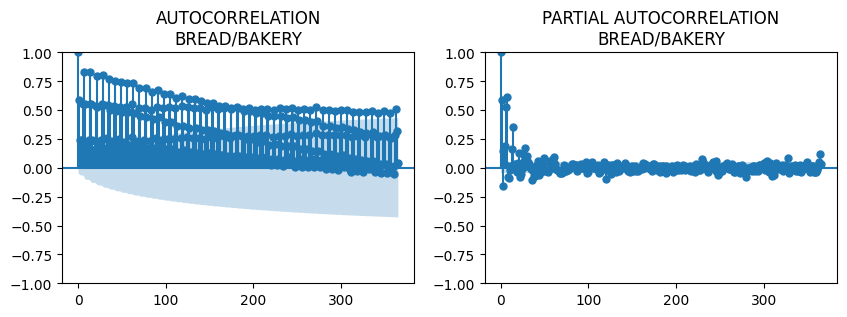

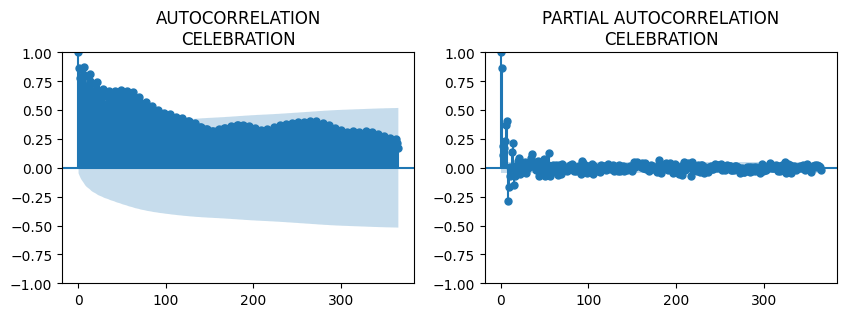

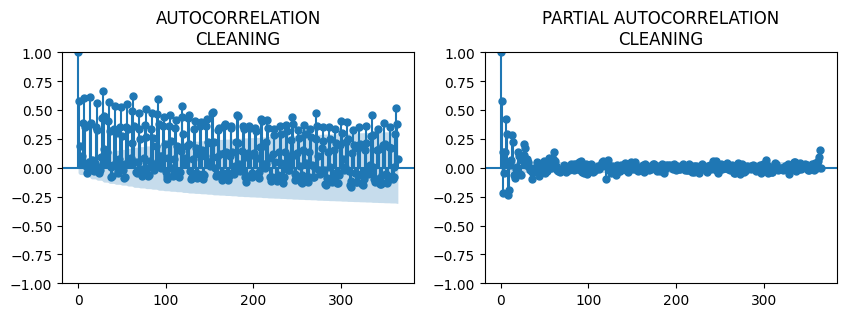

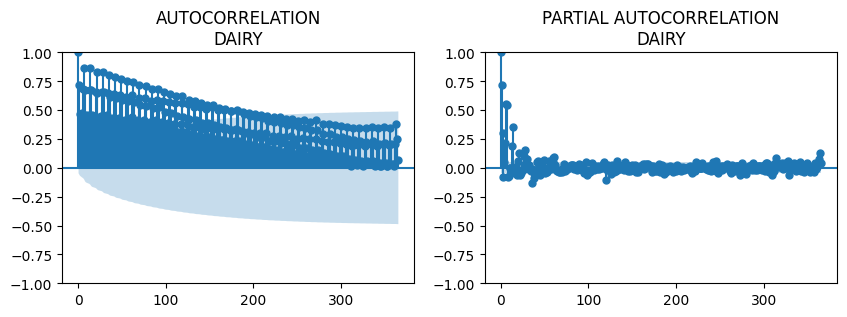

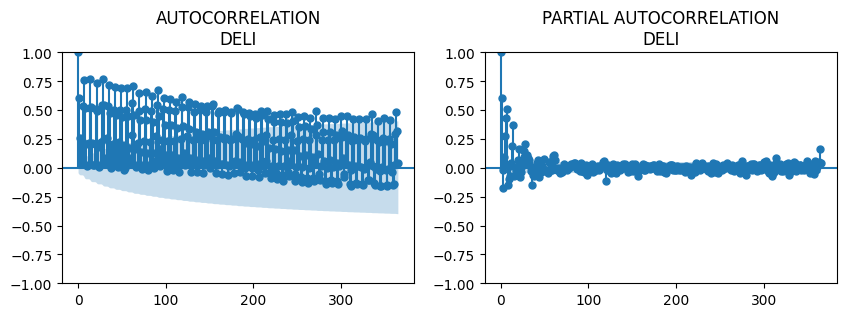

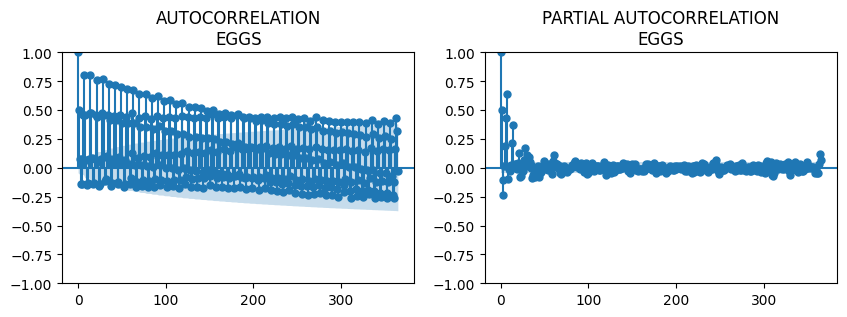

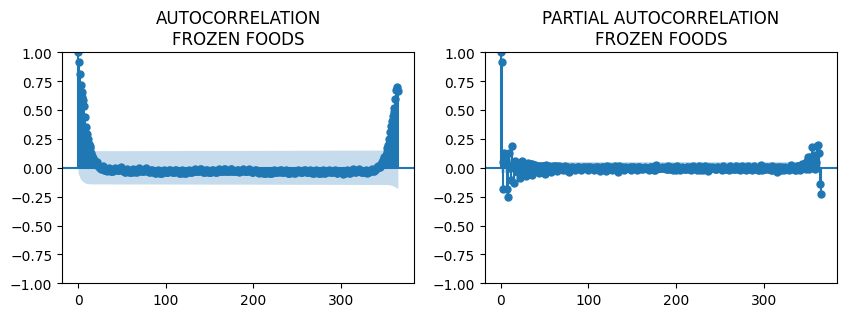

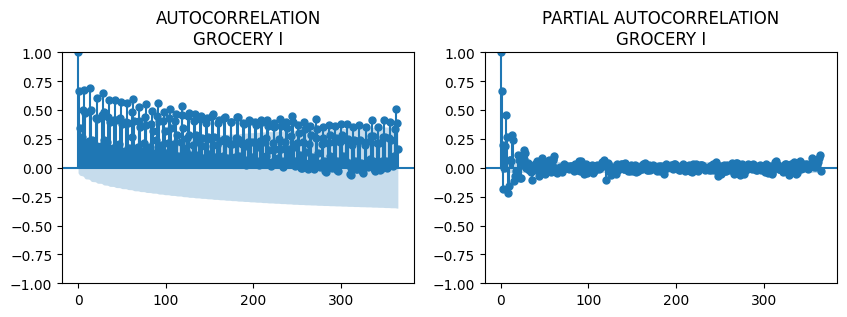

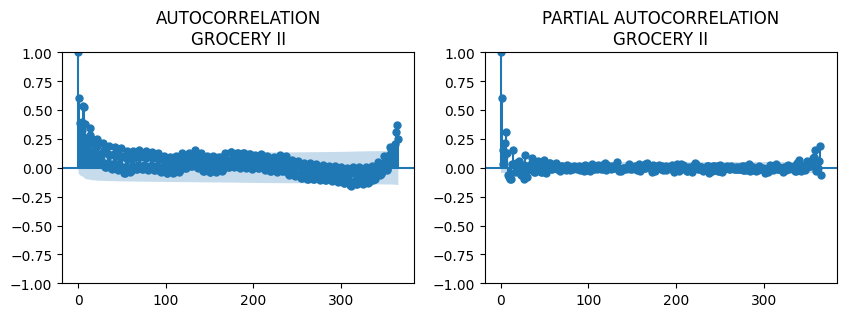

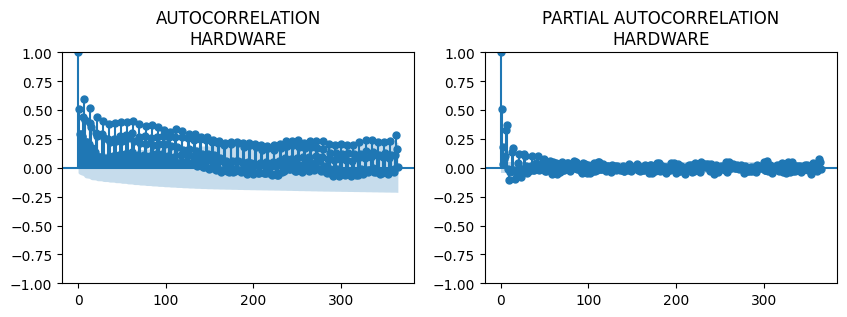

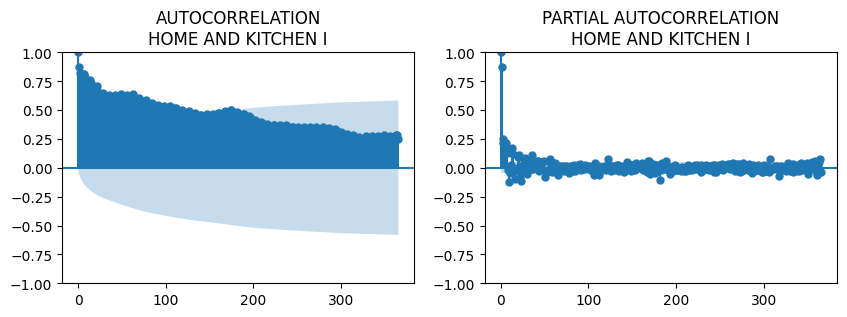

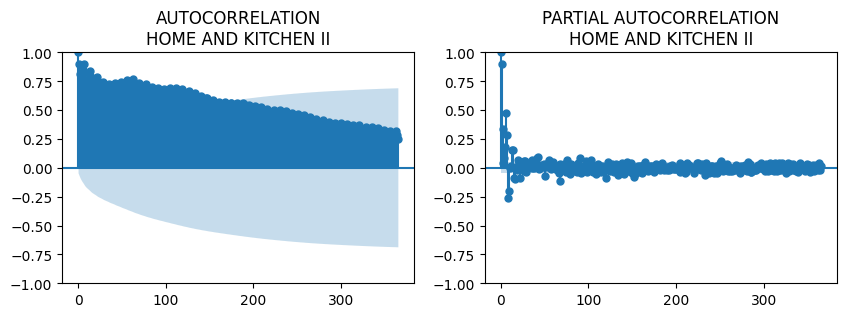

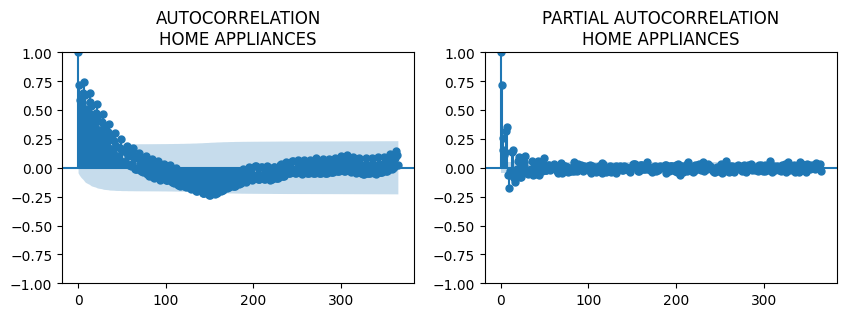

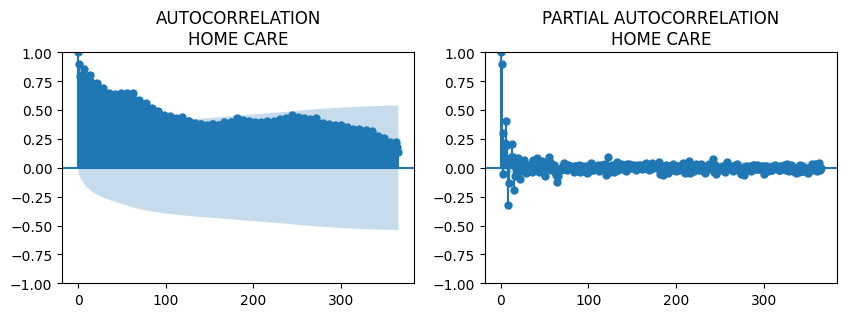

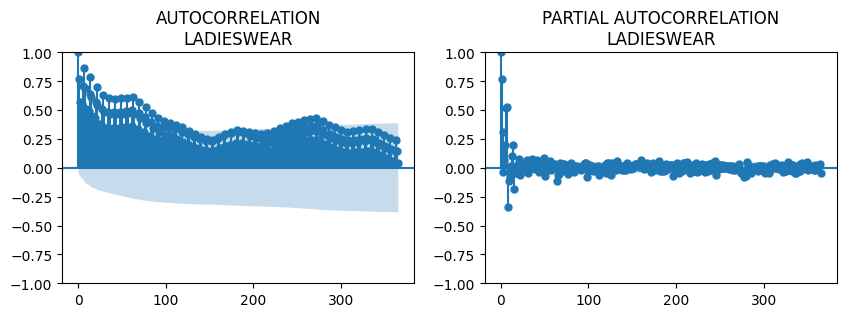

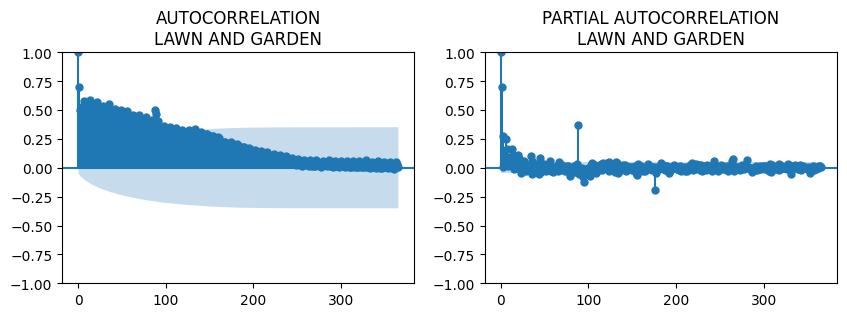

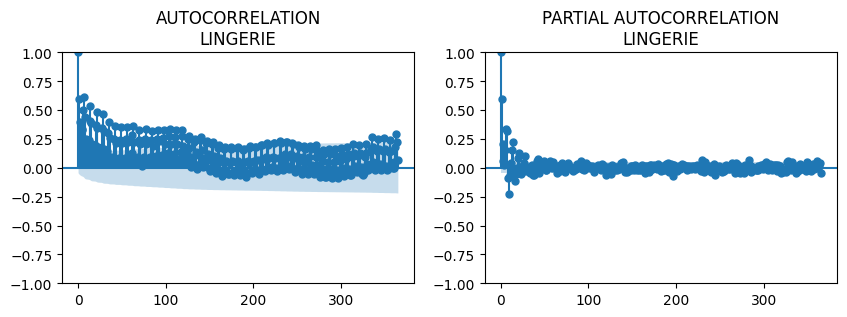

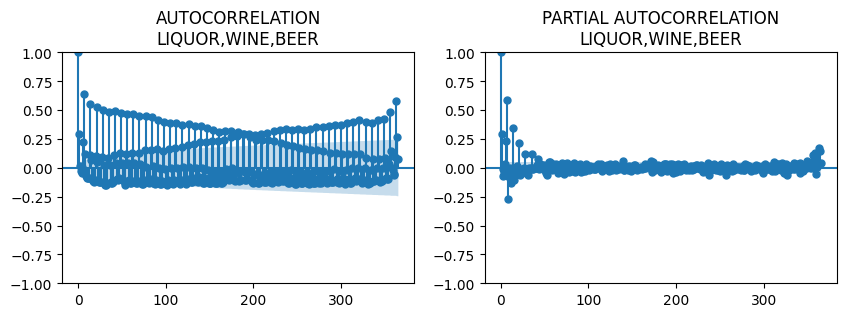

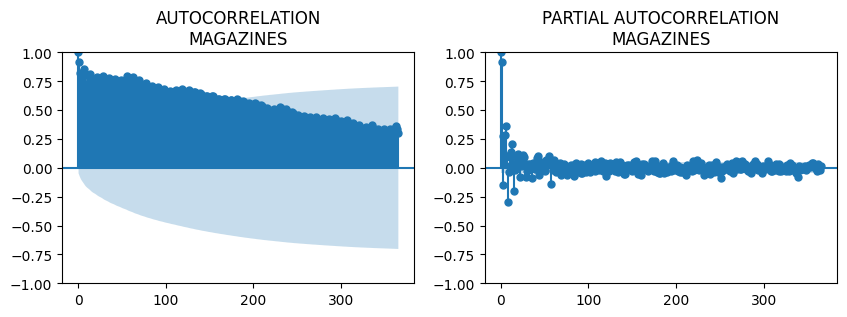

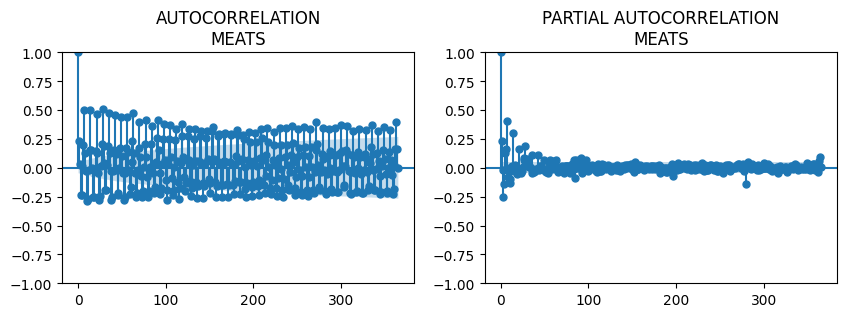

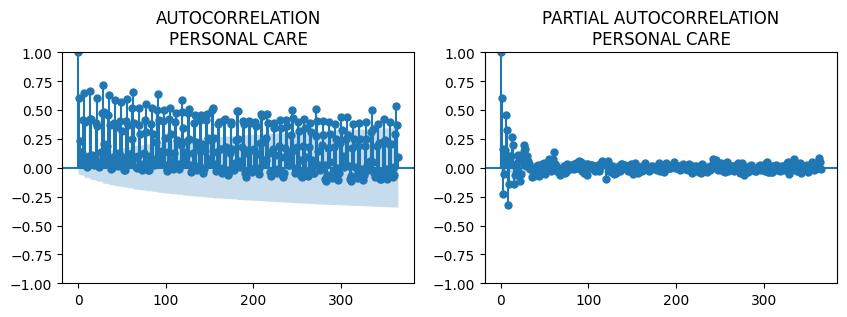

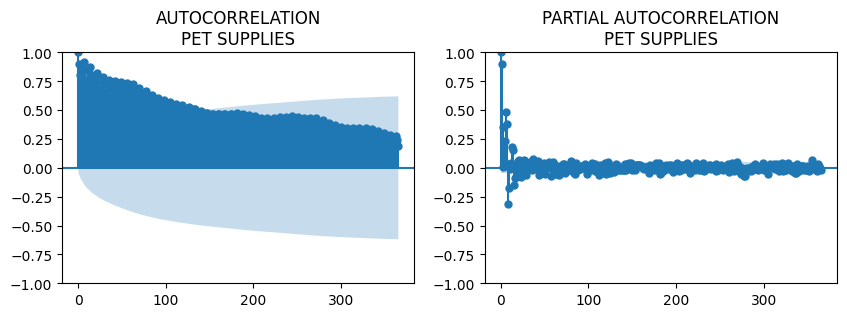

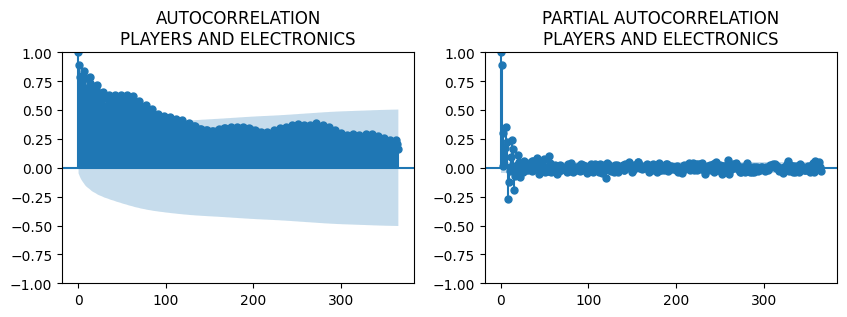

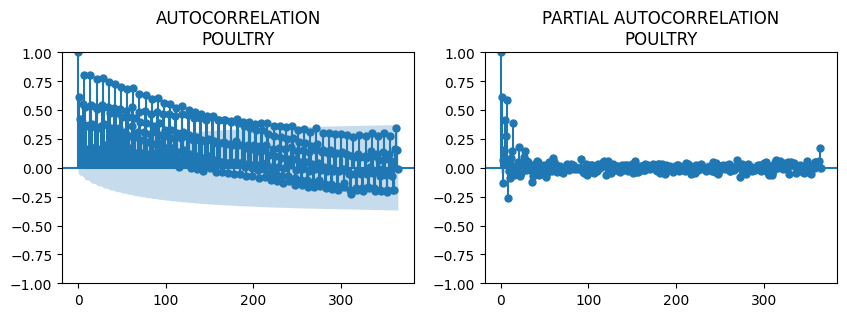

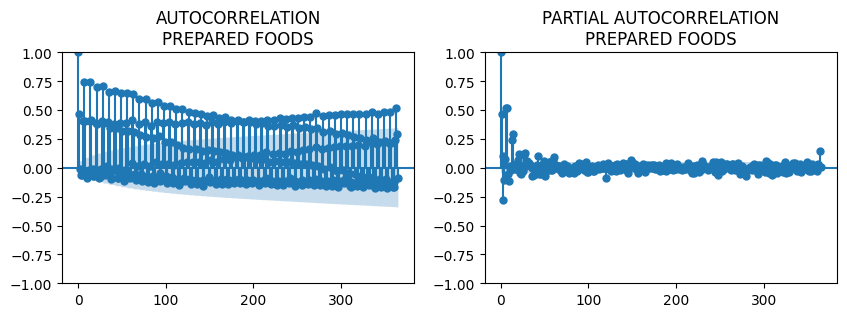

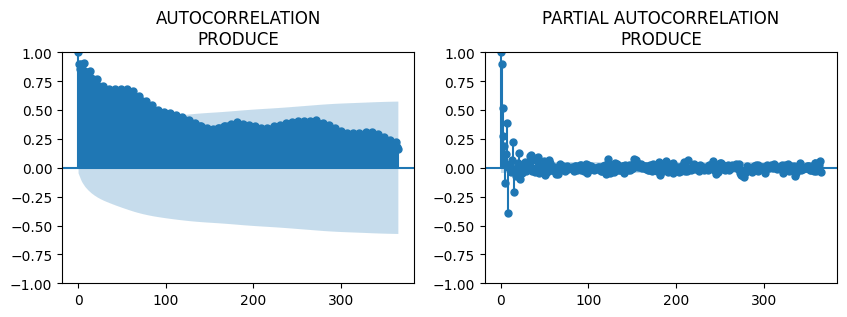

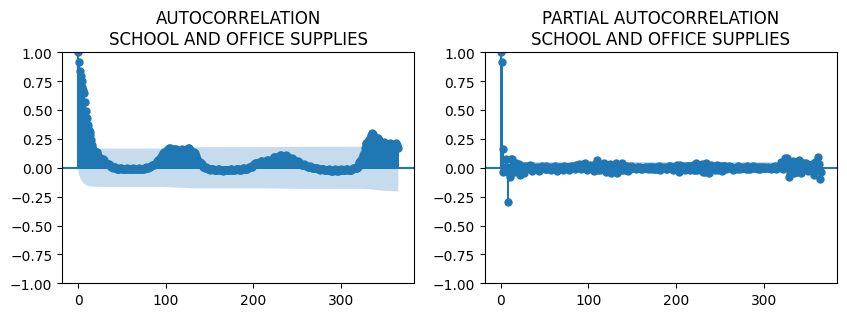

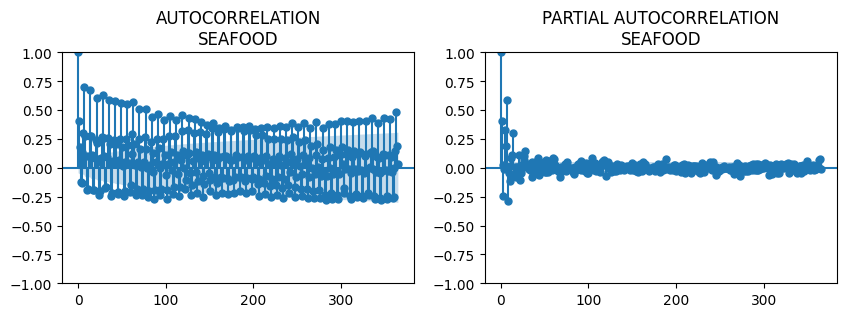

In [ ]:
# ACF and PACF

def find_optimal_lags(acf_values, pacf_values, threshold=0.6):
    """Finds significant lags based on a threshold for ACF and PACF."""
    acf_lags = [i for i, v in enumerate(acf_values) if abs(v) > threshold and i > 0]
    pacf_lags = [i for i, v in enumerate(pacf_values) if abs(v) > threshold and i > 0]
    return acf_lags, pacf_lags

optimal_acf_lags_counter = {}

optimal_pacf_lags_counter = {}

d = data.copy()
a = d[(d.sales.notnull())].groupby(["date", "family"]).sales.mean().reset_index().set_index("date")
for num, i in enumerate(a.family.unique()):
    try:
        fig, ax = plt.subplots(1,2,figsize=(10,3))
        temp = a[(a.family == i)]#& (a.sales.notnull())
        acf_values = acf(temp.sales, nlags=365)
        pacf_values = pacf(temp.sales, nlags=365)
        sm.graphics.tsa.plot_acf(temp.sales, lags=365, ax=ax[0], title = "AUTOCORRELATION\n" + i)
        sm.graphics.tsa.plot_pacf(temp.sales, lags=365, ax=ax[1], title = "PARTIAL AUTOCORRELATION\n" + i)

        acf_lags, pacf_lags = find_optimal_lags(acf_values, pacf_values)

        for lag in acf_lags:
          optimal_acf_lags_counter[lag] = optimal_acf_lags_counter.get(lag, 0) + 1

        for lag in pacf_lags:
          optimal_pacf_lags_counter[lag] = optimal_pacf_lags_counter.get(lag, 0) + 1

    except:
        pass
print("--------------")
print("ACF lags summary")

sorted_acf_lags = dict(sorted(optimal_acf_lags_counter.items(), key=lambda item: item[1], reverse=True))
print(sorted_acf_lags)

print("ACF lags summary")
print("--------------")

print("--------------")
print("PACF lags summary")

sorted_pacf_lags = dict(sorted(optimal_pacf_lags_counter.items(), key=lambda item: item[1], reverse=True))
print(sorted_pacf_lags)

print("PACF lags summary")
print("--------------")


##Data Exploration

###Impact of Holidays

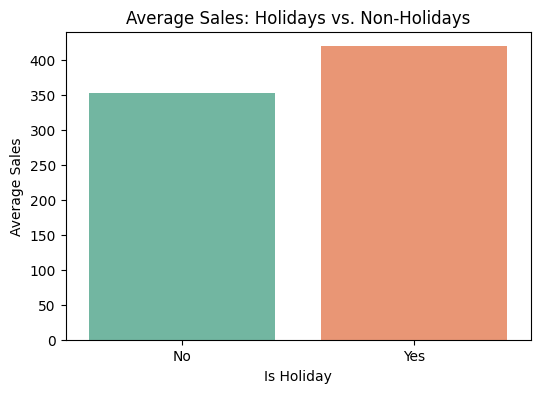

In [ ]:
# Aggregate sales based on 'is_holiday'
data['is_holiday'] = data[['is_national_holiday', 'is_regional_holiday', 'is_local_holiday']].max(axis=1)
holiday_sales = data.groupby('is_holiday')['sales'].mean().reset_index()
data.drop('is_holiday', axis=1, inplace=True)

# Plot average sales during holidays vs. non-holidays
plt.figure(figsize=(6, 4))
sns.barplot(data=holiday_sales, x='is_holiday', y='sales', palette='Set2', hue='is_holiday', legend=False)
plt.title('Average Sales: Holidays vs. Non-Holidays')
plt.xlabel('Is Holiday')
plt.ylabel('Average Sales')
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

Number of unique holidays: 103


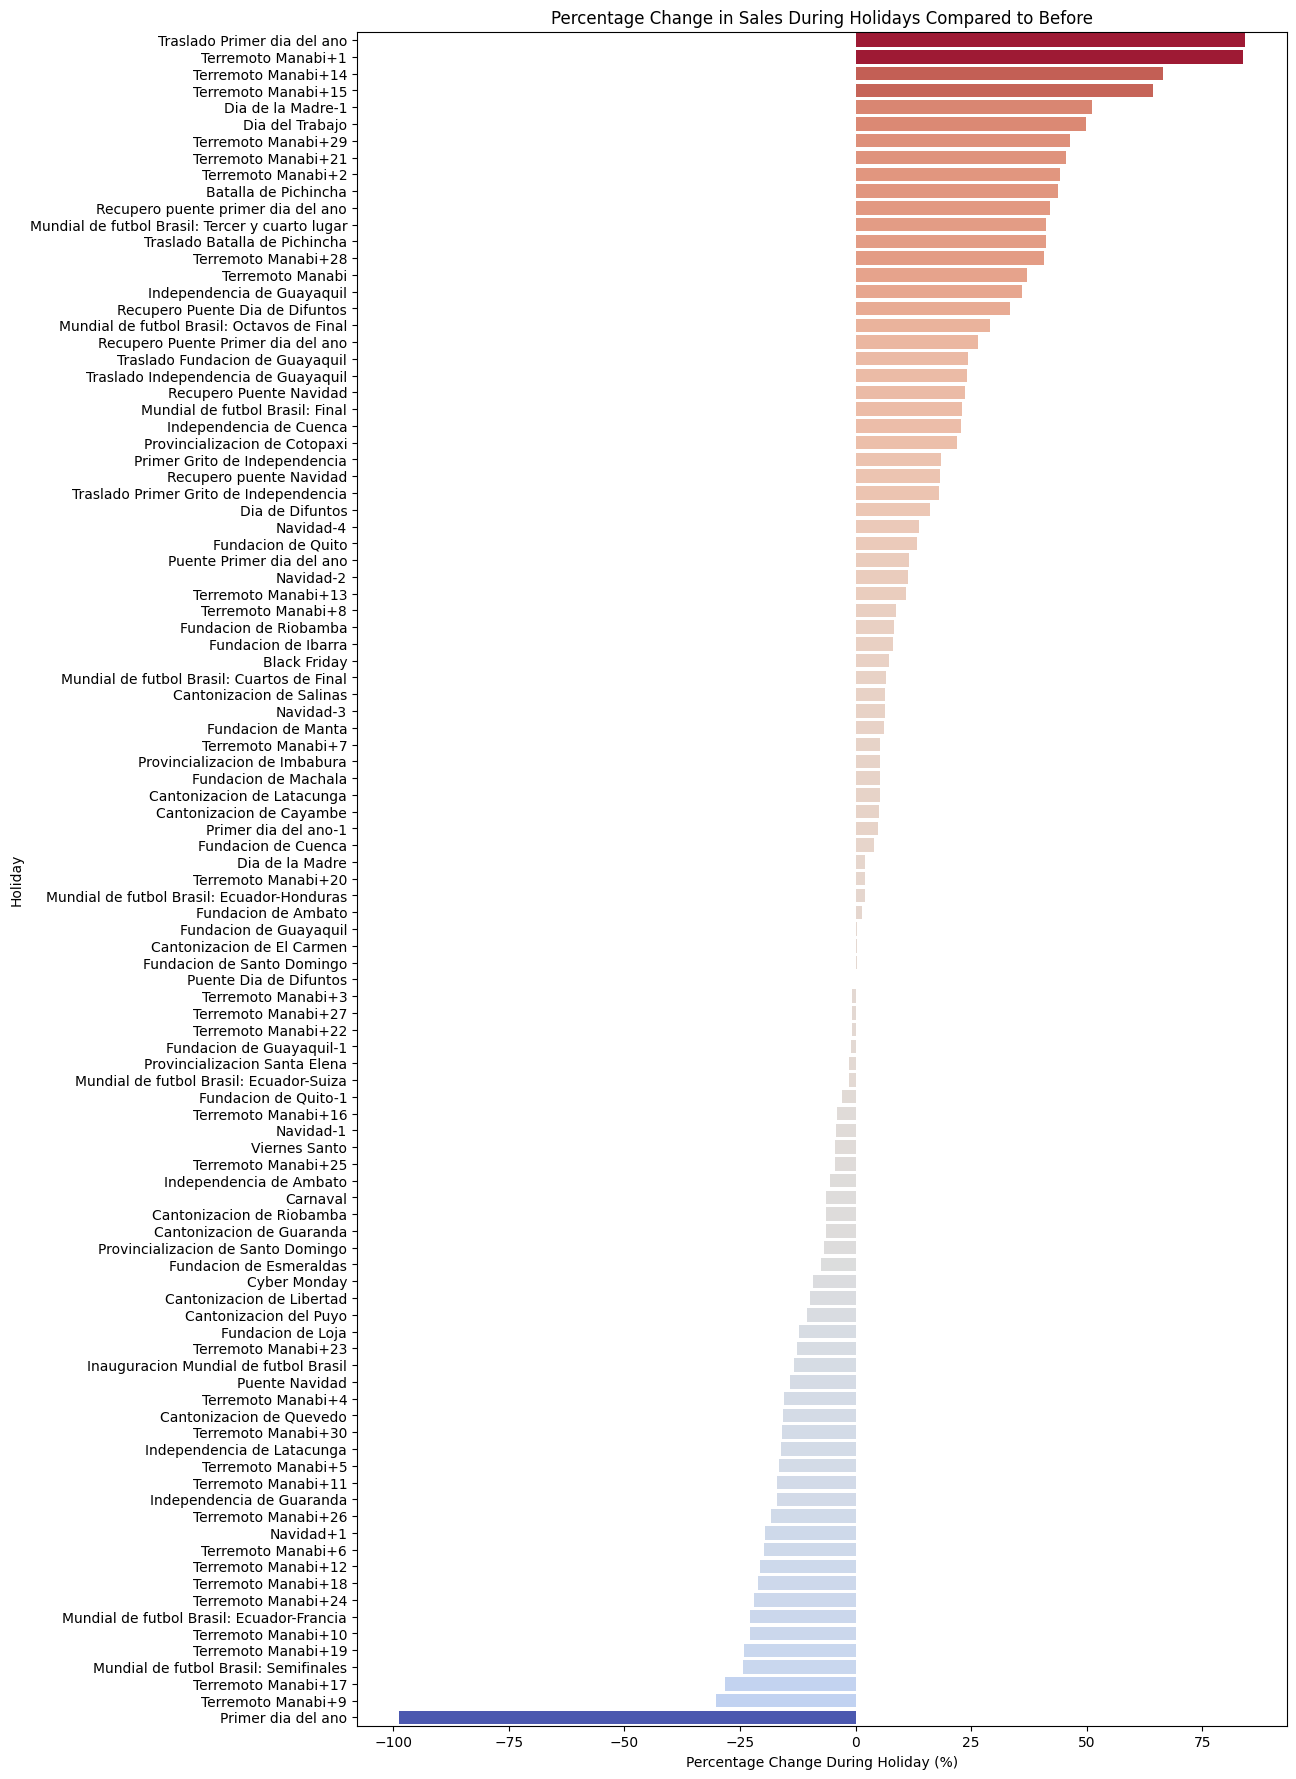

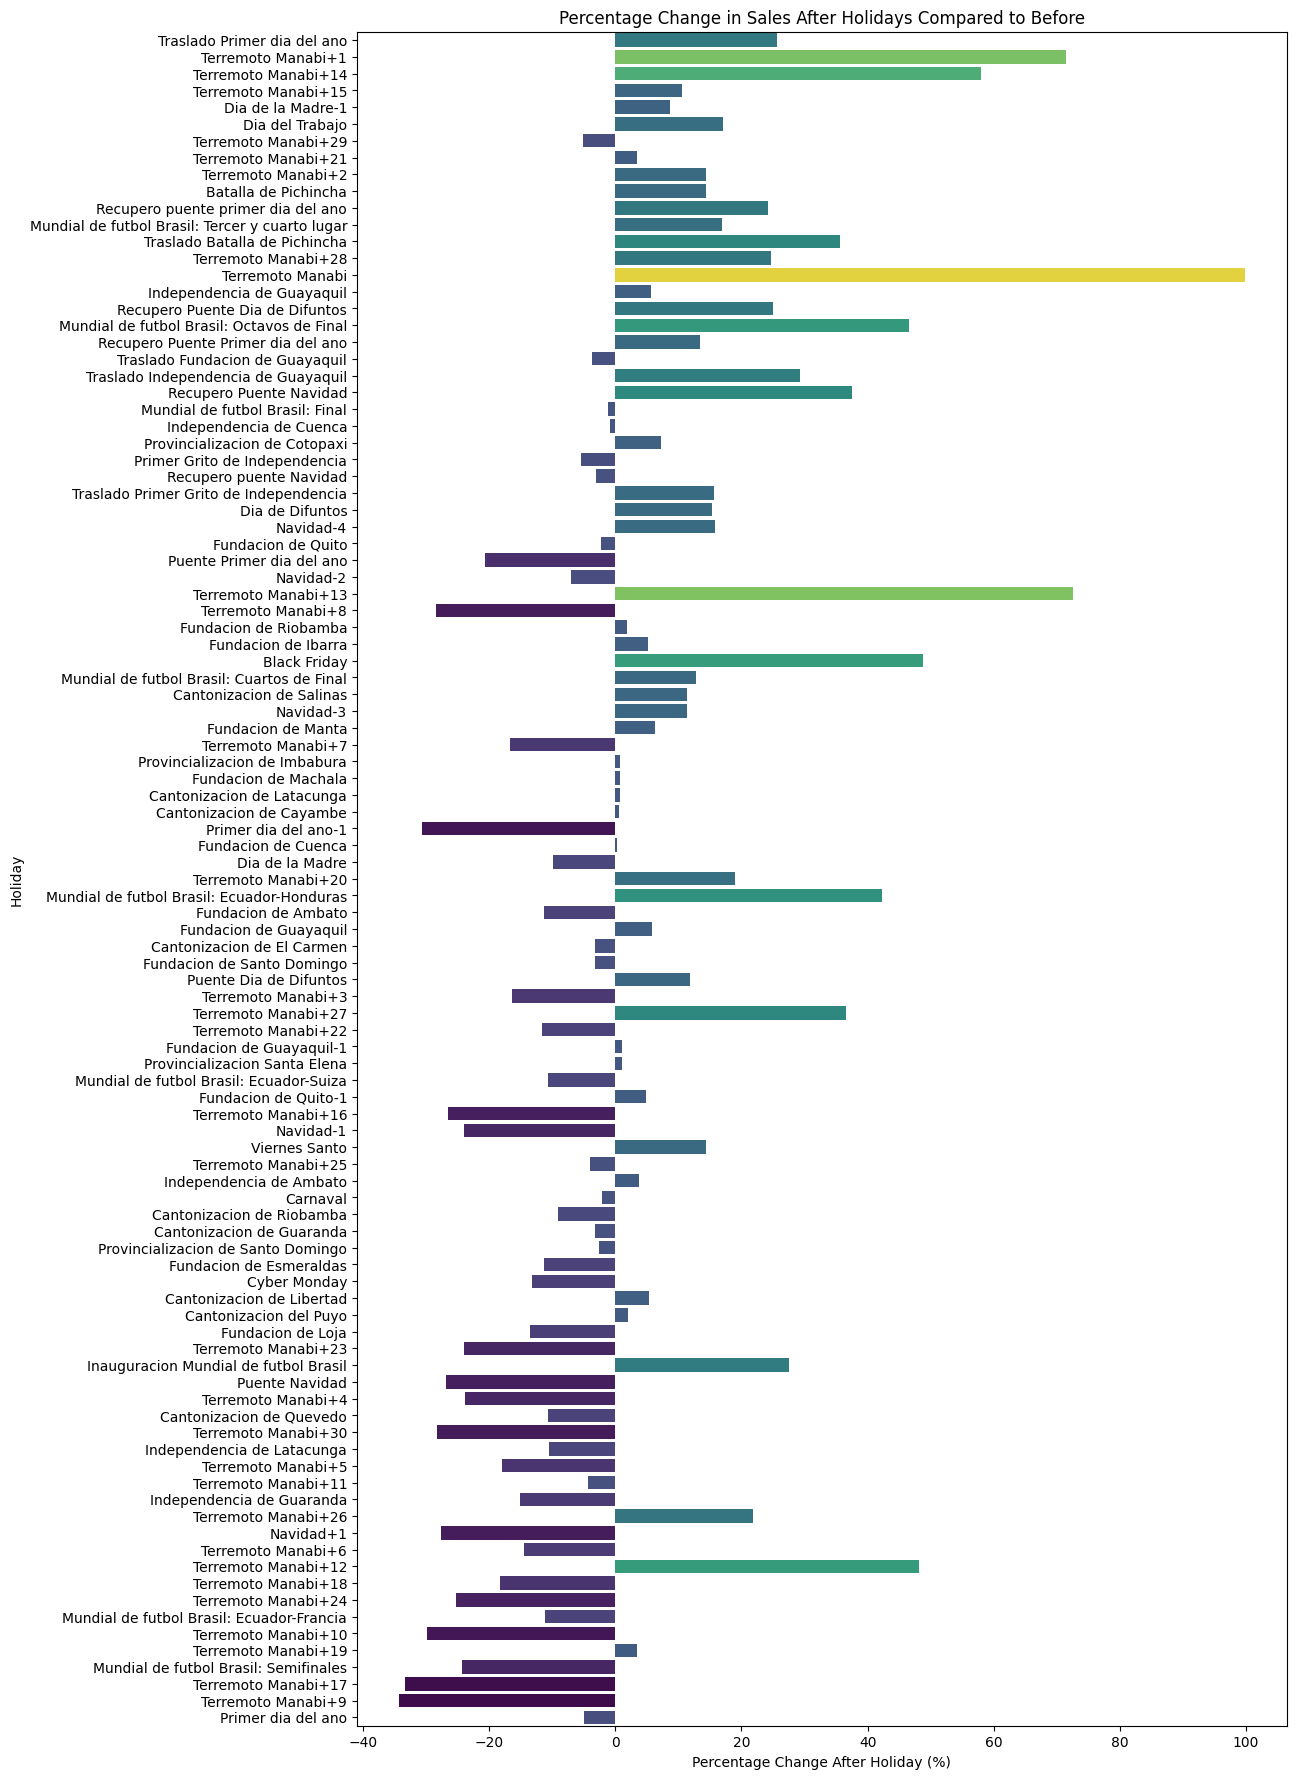

In [ ]:
unique_holidays = holiday['description'].unique()
print(f"Number of unique holidays: {len(unique_holidays)}")

# Initialize a list to store results
holiday_impact_list = []

# Number of days to consider before and after the holiday
days_before = 3
days_after = 3

# Iterate over each unique holiday
for hol in unique_holidays:
    # Get the dates for the current holiday
    holiday_dates = holiday[holiday['description'] == hol]['date']

    sales_before = []
    sales_during = []
    sales_after = []

    for date in holiday_dates:
        start_date_before = date - pd.Timedelta(days=days_before)
        end_date_before = date - pd.Timedelta(days=1)
        mask_before = (data['date'] >= start_date_before) & (data['date'] <= end_date_before)
        sales_before.extend(data.loc[mask_before, 'sales'])

        mask_during = data['date'] == date
        sales_during.extend(data.loc[mask_during, 'sales'])

        start_date_after = date + pd.Timedelta(days=1)
        end_date_after = date + pd.Timedelta(days=days_after)
        mask_after = (data['date'] >= start_date_after) & (data['date'] <= end_date_after)
        sales_after.extend(data.loc[mask_after, 'sales'])

    avg_sales_before = np.mean(sales_before) if sales_before else np.nan
    avg_sales_during = np.mean(sales_during) if sales_during else np.nan
    avg_sales_after = np.mean(sales_after) if sales_after else np.nan

    holiday_impact_list.append({
        'Holiday': hol,
        'Average_Sales_Before': avg_sales_before,
        'Average_Sales_During': avg_sales_during,
        'Average_Sales_After': avg_sales_after
    })

holiday_impact = pd.DataFrame(holiday_impact_list)

holiday_impact.dropna(inplace=True)

holiday_impact['Percent_Change_During'] = ((holiday_impact['Average_Sales_During'] - holiday_impact['Average_Sales_Before']) / holiday_impact['Average_Sales_Before']) * 100

holiday_impact['Percent_Change_After'] = ((holiday_impact['Average_Sales_After'] - holiday_impact['Average_Sales_Before']) / holiday_impact['Average_Sales_Before']) * 100

# Sort the DataFrame by percentage change during the holiday
holiday_impact_sorted = holiday_impact.sort_values(by='Percent_Change_During', ascending=False)

# Plot percentage change during the holiday
plt.figure(figsize=(12, 22))
sns.barplot(data=holiday_impact_sorted, x='Percent_Change_During', y='Holiday', palette='coolwarm', hue='Percent_Change_During', legend=False)
plt.title('Percentage Change in Sales During Holidays Compared to Before')
plt.xlabel('Percentage Change During Holiday (%)')
plt.ylabel('Holiday')
plt.show()

# Plot percentage change after the holiday
plt.figure(figsize=(12, 22))
sns.barplot(data=holiday_impact_sorted, x='Percent_Change_After', y='Holiday', palette='viridis', hue='Percent_Change_After', legend=False)
plt.title('Percentage Change in Sales After Holidays Compared to Before')
plt.xlabel('Percentage Change After Holiday (%)')
plt.ylabel('Holiday')
plt.show()

###Impact of temporal components

<ipython-input-41-9c4131a1c3b7>:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[2, 0].set_xticklabels(['Weekday', 'Weekend'])


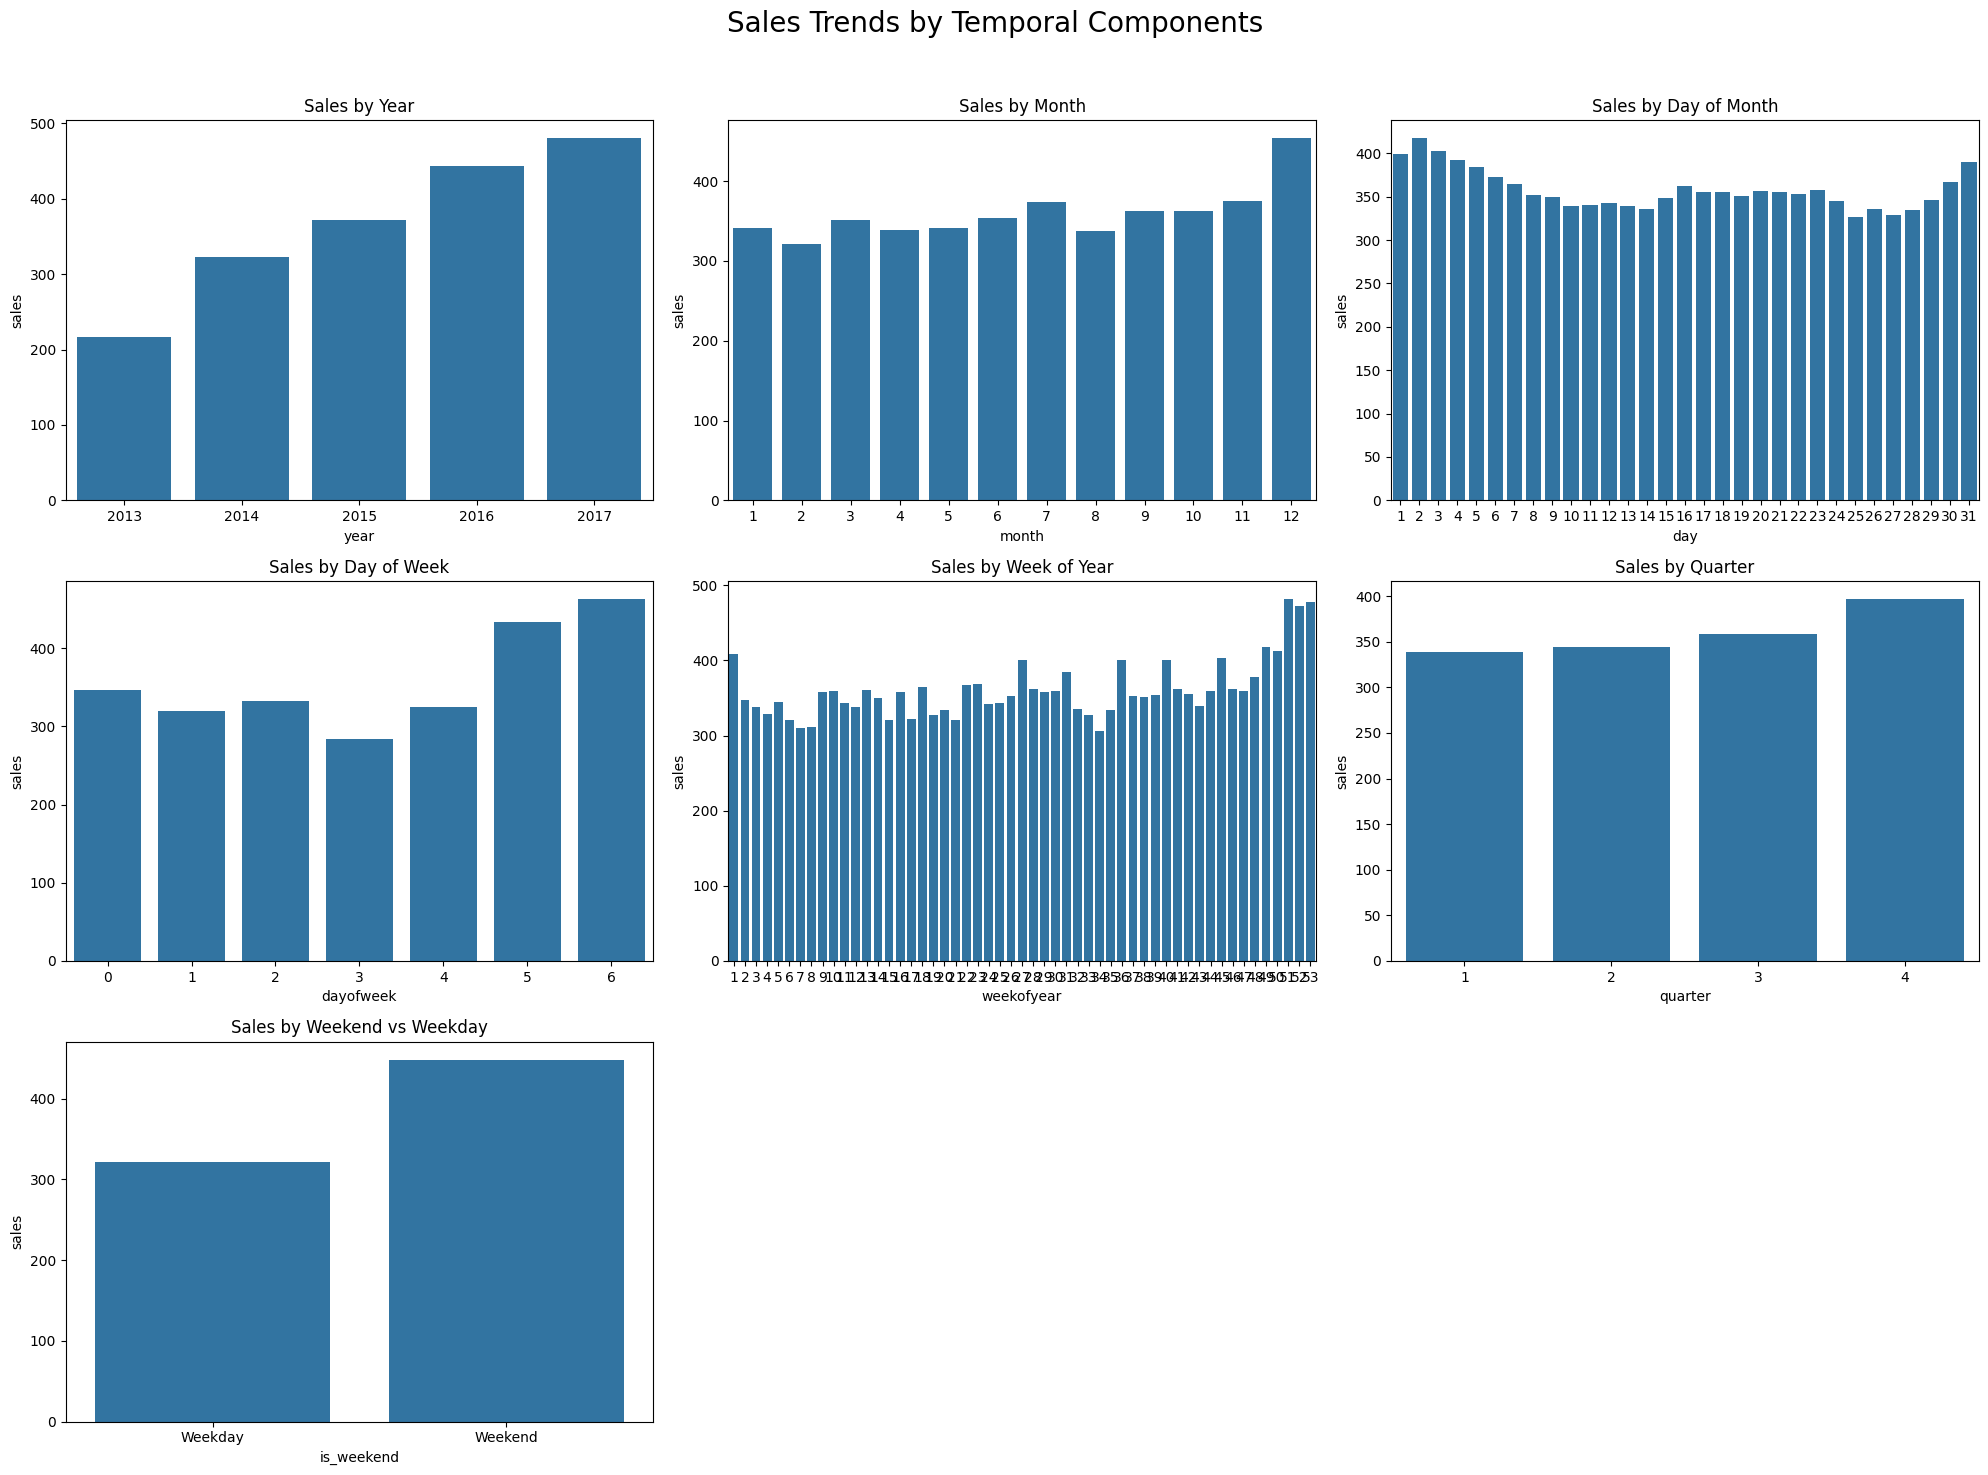

In [ ]:
# Set up a large figure with subplots for each time component
fig, axs = plt.subplots(3, 3, figsize=(20, 15))
fig.suptitle('Sales Trends by Temporal Components', fontsize=20)

# Yearly sales trend
sns.barplot(x='year', y='sales', data=data, ax=axs[0, 0], errorbar=None)
axs[0, 0].set_title('Sales by Year')

# Monthly sales trend
sns.barplot(x='month', y='sales', data=data, ax=axs[0, 1], errorbar=None)
axs[0, 1].set_title('Sales by Month')

# Daily sales trend
sns.barplot(x='day', y='sales', data=data, ax=axs[0, 2], errorbar=None)
axs[0, 2].set_title('Sales by Day of Month')

# Day of the week sales trend
sns.barplot(x='dayofweek', y='sales', data=data, ax=axs[1, 0], errorbar=None)
axs[1, 0].set_title('Sales by Day of Week')

# Week of the year sales trend
sns.barplot(x='weekofyear', y='sales', data=data, ax=axs[1, 1], errorbar=None)
axs[1, 1].set_title('Sales by Week of Year')

# Quarterly sales trend
sns.barplot(x='quarter', y='sales', data=data, ax=axs[1, 2], errorbar=None)
axs[1, 2].set_title('Sales by Quarter')

# Sales trend by weekend vs. weekday
sns.barplot(x='is_weekend', y='sales', data=data, ax=axs[2, 0], errorbar=None)
axs[2, 0].set_title('Sales by Weekend vs Weekday')
axs[2, 0].set_xticklabels(['Weekday', 'Weekend'])

# Hide unused subplots in the 3x3 grid
axs[2, 1].axis('off')
axs[2, 2].axis('off')

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Impact on Average Sales

Covariates: oil, onpromotion, transactions
Past covariates  : transactions
Future covariates: oil, onpromotion
mean_oil_ts_scaled Index(['date', 'oil'], dtype='object')


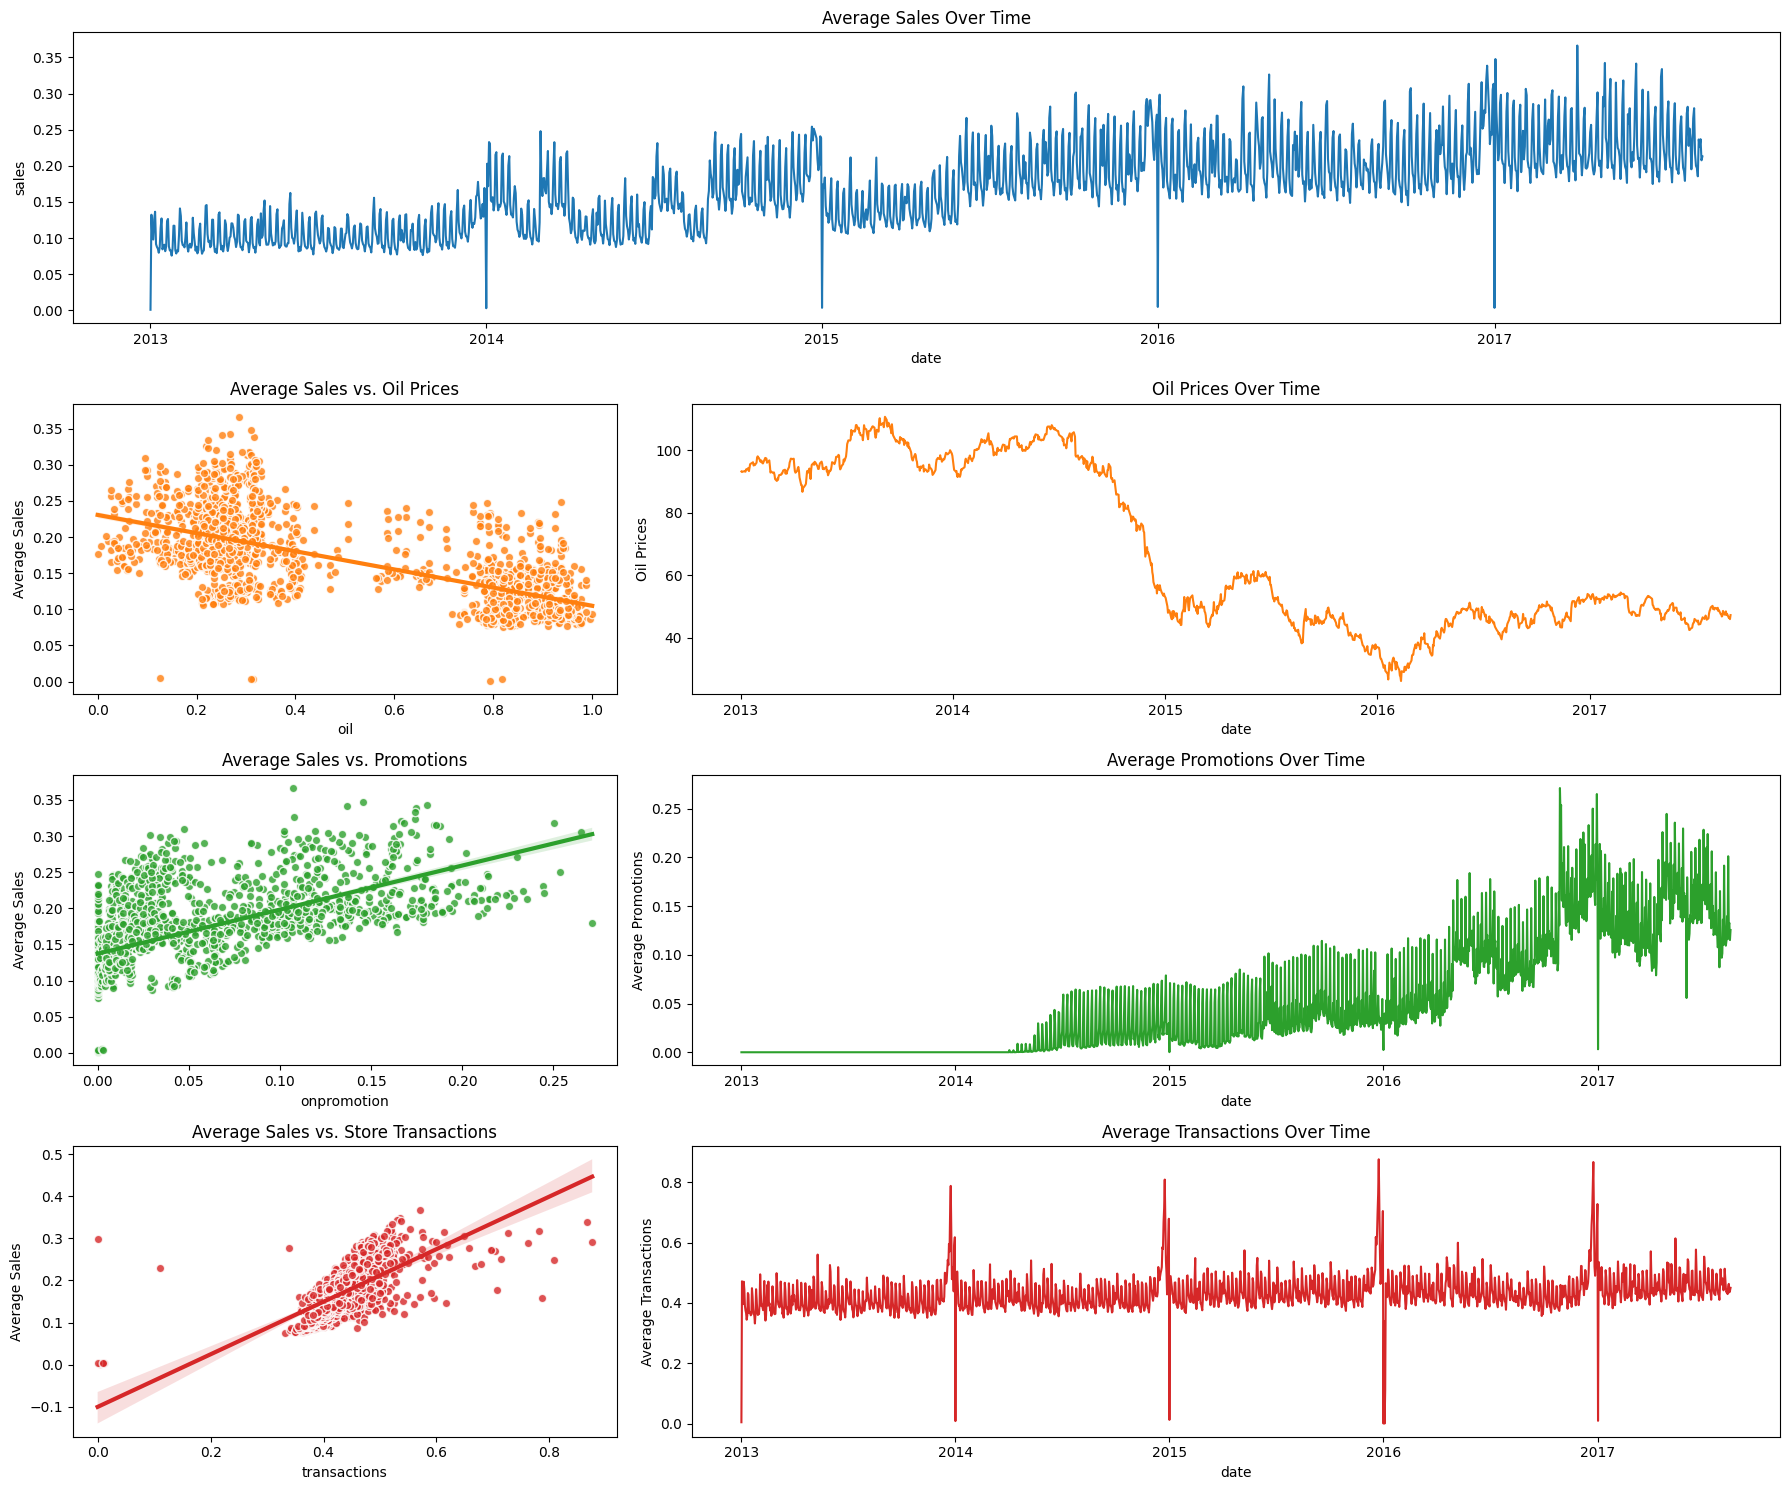

In [ ]:
sales_ts = pd.pivot_table(data, values="sales", index="date", columns=["store_nbr", "family"])
tr_ts = pd.pivot_table(data, values="transactions", index="date", columns="store_nbr")
promo_ts = pd.pivot_table(data, values="onpromotion", index="date", columns=["store_nbr", "family"])
oil_ts = pd.pivot_table(data, values="oil", index="date", columns=["store_nbr", "family"])


# scale target series
scaler = MinMaxScaler()
sales_ts_scaled = sales_ts.copy()
sales_ts_scaled[sales_ts_scaled.columns] = scaler.fit_transform(sales_ts_scaled)

sales_ts.head()

def plot_sales_correlation():
    tr_ts_scaled = tr_ts.copy()
    tr_ts_scaled[tr_ts_scaled.columns] = scaler.fit_transform(tr_ts_scaled)

    promo_ts_scaled = promo_ts.copy()
    promo_ts_scaled[promo_ts_scaled.columns] = scaler.fit_transform(promo_ts_scaled)

    oil_ts_scaled = oil_ts.copy()
    oil_ts_scaled[oil_ts_scaled.columns] = scaler.fit_transform(oil_ts_scaled)

    # holiday_ts_scaled = holiday_ts.copy()
    # holiday_ts_scaled[holiday_ts_scaled.columns] = scaler.fit_transform(holiday_ts_scaled)

    mean_sales_ts_scaled = sales_ts_scaled.mean(axis=1).to_frame("sales").reset_index()
    mean_oil_ts_scaled = oil_ts_scaled.mean(axis=1).to_frame("oil").reset_index()
    mean_promo_ts_scaled = promo_ts_scaled.mean(axis=1).to_frame("onpromotion").reset_index()
    mean_tr_ts_scaled = tr_ts_scaled.mean(axis=1).to_frame("transactions").reset_index()
    # mean_holiday_ts_scaled = holiday_ts.mean(axis=1).to_frame("is_holiday").reset_index()

    cprint(
        "Covariates: oil, onpromotion, transactions",
        "Past covariates  : transactions",
        "Future covariates: oil, onpromotion",
    )

    plot_kwargs = {
        "scatter_kws": {"edgecolor": "white"},
        "line_kws": {"lw": 3},
    }

    fig = plt.figure(figsize=(18, 15))
    gs = fig.add_gridspec(4, 2, width_ratios=(1, 2))

    sns.lineplot(
        data=mean_sales_ts_scaled,
        x="date",
        y="sales",
        ax=fig.add_subplot(gs[0, :]),
    )
    plt.title("Average Sales Over Time")

    print("mean_oil_ts_scaled", mean_oil_ts_scaled.columns)

    sns.regplot(
        x=mean_oil_ts_scaled.oil,
  # oil.oil.iloc[:train_len],
        y=mean_sales_ts_scaled.sales,
        ax=fig.add_subplot(gs[1, 0]),
        color=COLORS[1],
        **plot_kwargs,
    )
    plt.ylabel("Average Sales")
    plt.title("Average Sales vs. Oil Prices")

    sns.lineplot(
        data=oil.iloc[:data_len, :], x="date", y="oil",
        ax=fig.add_subplot(gs[1, 1]),
        color=COLORS[1],
    )
    plt.ylabel("Oil Prices")
    plt.title("Oil Prices Over Time")

    sns.regplot(
        x=mean_promo_ts_scaled.onpromotion, y=mean_sales_ts_scaled.sales,
        ax=fig.add_subplot(gs[2, 0]),
        color=COLORS[2],
        **plot_kwargs,
    )
    plt.xlabel("onpromotion")
    plt.ylabel("Average Sales")
    plt.title("Average Sales vs. Promotions")

    sns.lineplot(
        data=mean_promo_ts_scaled, x="date", y="onpromotion",
        ax=fig.add_subplot(gs[2, 1]),
        color=COLORS[2],
    )
    plt.ylabel("Average Promotions")
    plt.title("Average Promotions Over Time")

    sns.regplot(
        x=mean_tr_ts_scaled.transactions, y=mean_sales_ts_scaled.sales,
        ax=fig.add_subplot(gs[3, 0]),
        color=COLORS[3],
        **plot_kwargs,
    )
    plt.xlabel("transactions")
    plt.ylabel("Average Sales")
    plt.title("Average Sales vs. Store Transactions")

    sns.lineplot(
        data=mean_tr_ts_scaled, x="date", y="transactions",
        ax=fig.add_subplot(gs[3, 1]),
        color=COLORS[3],
    )
    plt.ylabel("Average Transactions")
    plt.title("Average Transactions Over Time")

    plt.tight_layout()
    plt.show()

plot_sales_correlation()

##Encoding Categorical Features

In [ ]:
# Initialize LabelEncoders
le_family = LabelEncoder()
le_city = LabelEncoder()
le_state = LabelEncoder()
le_store_type = LabelEncoder()

data['family_encoded'] = le_family.fit_transform(data['family'])
data['city_encoded'] = le_city.fit_transform(data['city'])
data['state_encoded'] = le_state.fit_transform(data['state'])
data['store_type_encoded'] = le_store_type.fit_transform(data['type'])
data['cluster'] = data['cluster'].astype(int)
data.drop(columns=['family', 'city', 'state', 'type'], inplace=True)

##Feature Correlation

Pearson Correlation Coefficient

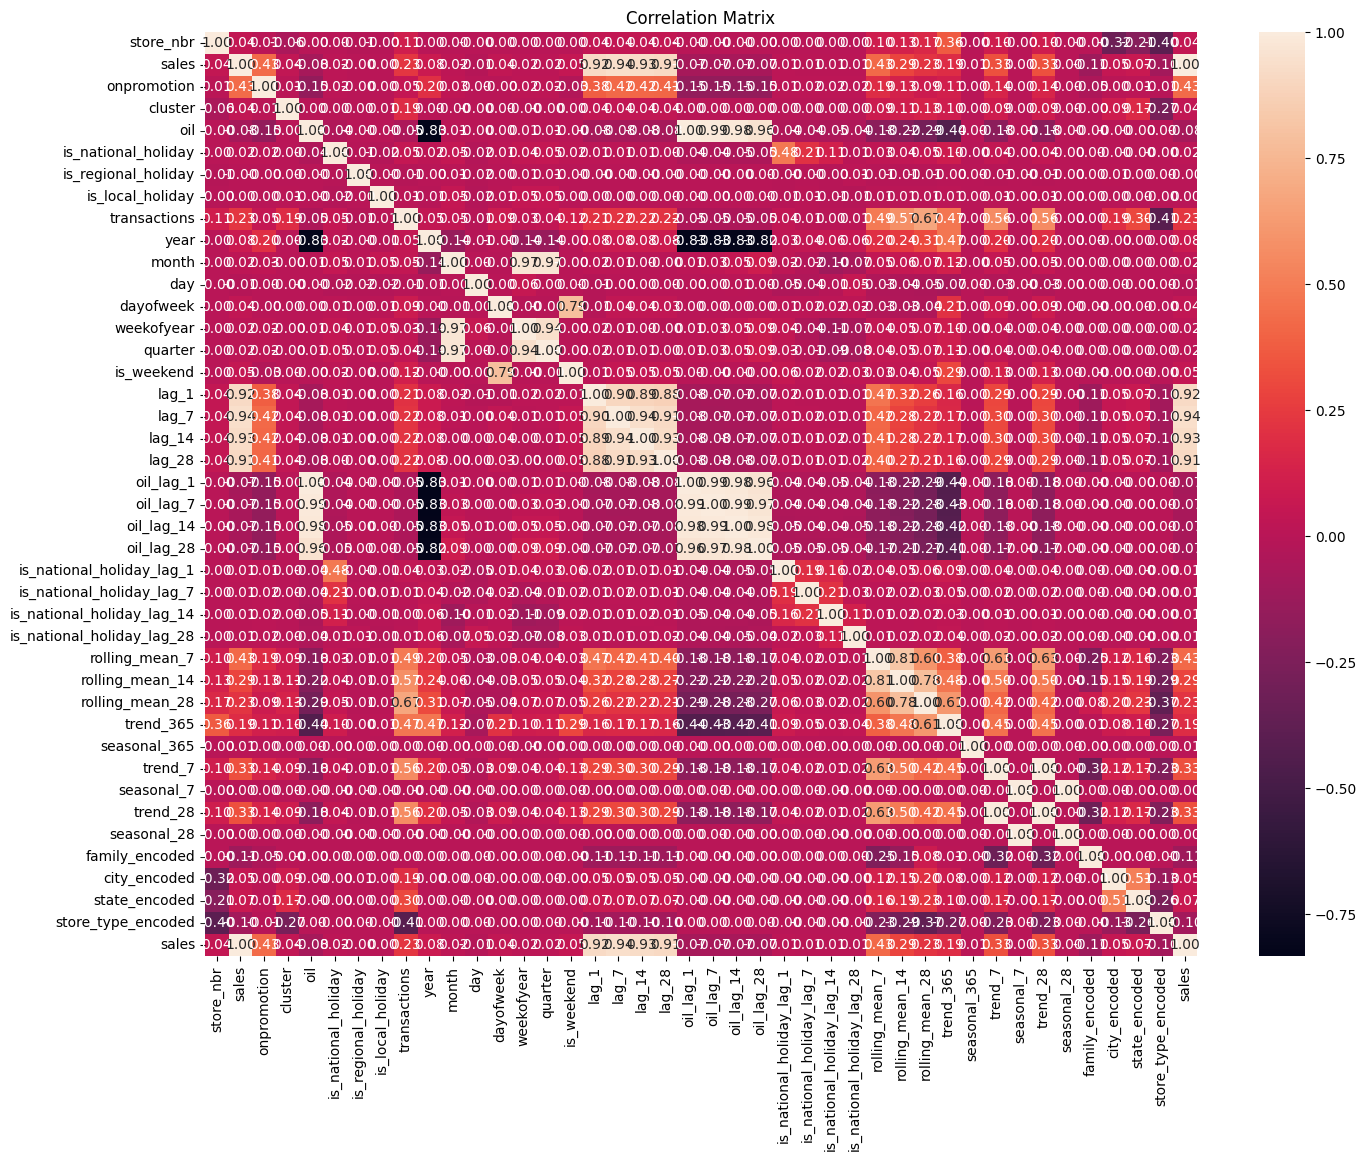

In [ ]:
# Define features to exclude
exclude_columns = ['id', 'date']
# Filter out excluded columns
features = [col for col in data.columns if col not in exclude_columns]
target = 'sales'

# Create correlation catrix
corr_matrix = data[features + [target]].corr()

# Plot it
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# Drop duplicates
corr_matrix = corr_matrix.loc[:, ~corr_matrix.columns.duplicated()]

# Extract correlation values with the target as a Series
correlations = corr_matrix[target].drop(target, errors='ignore')

# Sort by absolute correlation value
top_correlated_features = correlations.abs().sort_values(ascending=False).head(20)

top_feature_list_corr = top_correlated_features.index.tolist()

# Print the result
print("Top 20 features most correlated with", target, ":")
print(top_correlated_features)

Top 20 features most correlated with sales :
lag_7                 0.935534
lag_14                0.927180
lag_1                 0.918811
lag_28                0.910344
onpromotion           0.427948
rolling_mean_7        0.425034
trend_28              0.329433
trend_7               0.329433
rolling_mean_14       0.285742
transactions          0.233084
rolling_mean_28       0.225448
trend_365             0.185363
family_encoded        0.114161
store_type_encoded    0.095768
year                  0.081099
oil                   0.075046
oil_lag_1             0.074642
oil_lag_7             0.073796
oil_lag_14            0.072235
oil_lag_28            0.069393
Name: sales, dtype: float64


Tree-based model feature importance

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.670718 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4821
[LightGBM] [Info] Number of data points in the train set: 2401106, number of used features: 40
[LightGBM] [Info] Start training from score 357.402291
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

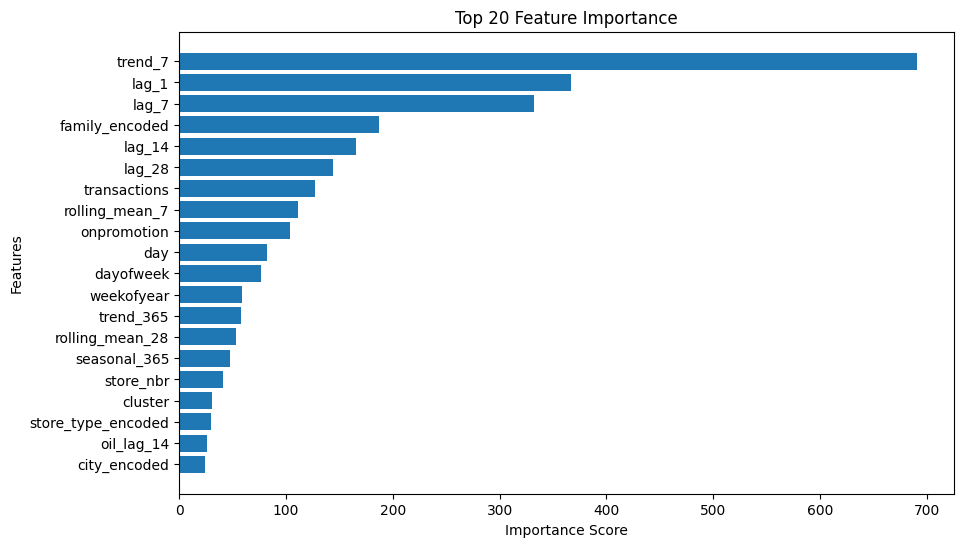

Top 20 features: ['trend_7', 'lag_1', 'lag_7', 'family_encoded', 'lag_14', 'lag_28', 'transactions', 'rolling_mean_7', 'onpromotion', 'day', 'dayofweek', 'weekofyear', 'trend_365', 'rolling_mean_28', 'seasonal_365', 'store_nbr', 'cluster', 'store_type_encoded', 'oil_lag_14', 'city_encoded']


In [ ]:
# Step 1: Separate features and target
X = data.drop(['sales', 'id', 'date'], axis=1)  # Feature columns
y = data['sales']              # Target column

# Step 2: Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Train a LightGBM model
lgb_model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
lgb_model.fit(X_train, y_train)

# Step 4: Extract feature importance
if hasattr(lgb_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': lgb_model.feature_importances_
    })

    # Sort features by importance and get the top 20
    top_features = feature_importance.sort_values(by='Importance', ascending=False).head(20)

    # Convert the top 20 features into a list
    top_feature_list_gbm = top_features['Feature'].tolist()

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(top_features['Feature'], top_features['Importance'])
    plt.title("Top 20 Feature Importance")
    plt.xlabel("Importance Score")
    plt.ylabel("Features")
    plt.gca().invert_yaxis()  # Invert y-axis to display the highest importance at the top
    plt.show()

# Print the top 20 features
print("Top 20 features:", top_feature_list_gbm)

## Feature Selection

In [ ]:
features = list(set(top_feature_list_corr).union(set(top_feature_list_gbm)))
print("Selected features: ", features)
X = data[features]
y = data['sales']

Selected features:  ['weekofyear', 'lag_7', 'family_encoded', 'rolling_mean_7', 'trend_7', 'transactions', 'seasonal_365', 'city_encoded', 'lag_14', 'store_nbr', 'rolling_mean_28', 'year', 'lag_28', 'day', 'dayofweek', 'oil', 'oil_lag_14', 'oil_lag_28', 'cluster', 'onpromotion', 'oil_lag_1', 'oil_lag_7', 'lag_1', 'rolling_mean_14', 'trend_365', 'store_type_encoded', 'trend_28']


In [ ]:
# Save the final data
final_df = pd.concat([X, y], axis=1)
final_df.to_csv(base_path + "final_data.csv", index=False)

In [ ]:
print(final_df.isnull().values.any())  # Returns True if there are any NaN values

False


### LOAD PRE-PROCESSED DATA

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd

base_path = "/content/drive/My Drive/412-Project/data/"
data = pd.read_csv(base_path+"final_data.csv")
X = data.drop(columns=['sales'])
y = data['sales']

Mounted at /content/drive


# Training Models

Evaluation Metric: Root Mean Square Logarithmic Error (RMSLE)

In [ ]:
def rmsle(y_true, y_pred):
    min_value = min(np.min(y_true), np.min(y_pred))
    shift = abs(min_value) + 1
    y_pred_shifted = y_pred + shift
    y_true_shifted = y_true + shift
    return np.sqrt(np.mean(np.square(np.log1p(y_pred_shifted) - np.log1p(y_true_shifted))))

## Statistical Models

###SARIMA

Processing Store 1, Family 0...


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


  Root Mean Squared Logarithmic Error (RMSLE): 0.9453059348728952
Store 1, Family 0:
  Mean Squared Error (MSE): 4.0
  Mean Absolute Error (MAE): 1.5
  Root Mean Squared Error (RMSE): 2.0
  Root Mean Squared Error (RMSLE): 0.9453059348728952


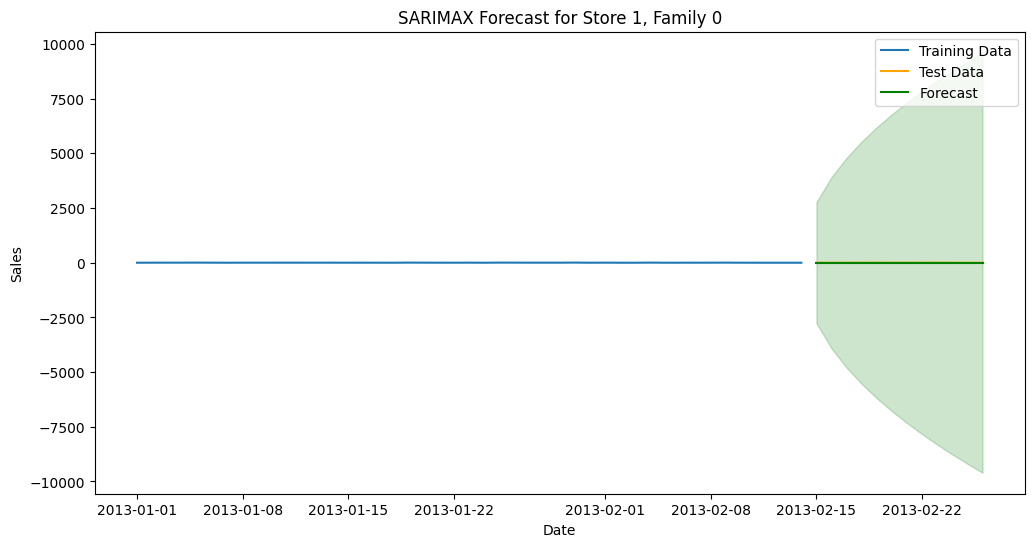

Processing Store 1, Family 1...


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


  Root Mean Squared Logarithmic Error (RMSLE): 0.0
Store 1, Family 1:
  Mean Squared Error (MSE): 0.0
  Mean Absolute Error (MAE): 0.0
  Root Mean Squared Error (RMSE): 0.0
  Root Mean Squared Error (RMSLE): 0.0


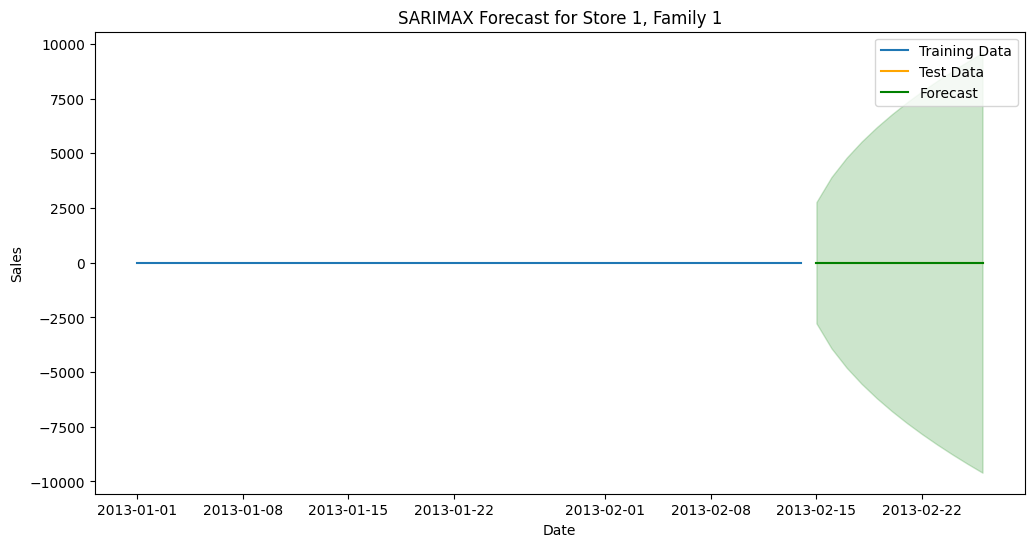

Processing Store 1, Family 2...


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


  Root Mean Squared Logarithmic Error (RMSLE): 0.5516867062154953
Store 1, Family 2:
  Mean Squared Error (MSE): 2.4166666666666665
  Mean Absolute Error (MAE): 0.9166666666666666
  Root Mean Squared Error (RMSE): 1.5545631755148024
  Root Mean Squared Error (RMSLE): 0.5516867062154953


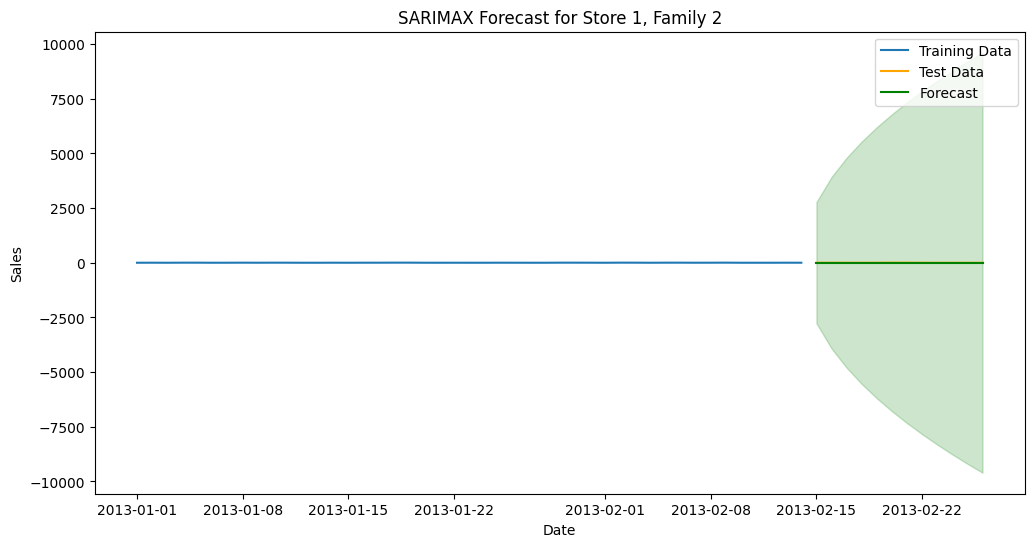

Processing Store 1, Family 3...


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


  Root Mean Squared Logarithmic Error (RMSLE): 0.36094015109812067
Store 1, Family 3:
  Mean Squared Error (MSE): 52267.333333333336
  Mean Absolute Error (MAE): 208.83333333333334
  Root Mean Squared Error (RMSE): 228.6205006847228
  Root Mean Squared Error (RMSLE): 0.36094015109812067


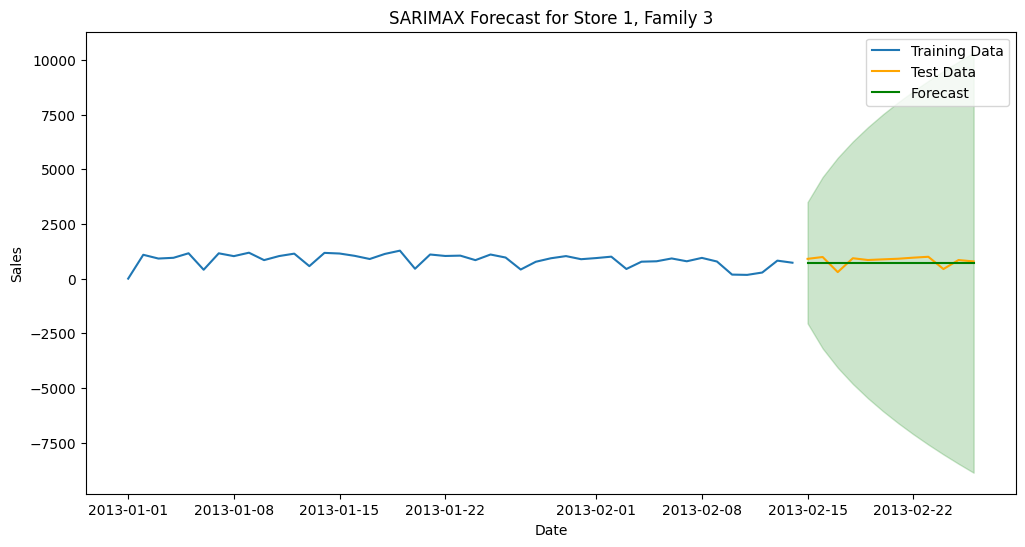

Processing Store 1, Family 4...


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


  Root Mean Squared Logarithmic Error (RMSLE): 0.0
Store 1, Family 4:
  Mean Squared Error (MSE): 0.0
  Mean Absolute Error (MAE): 0.0
  Root Mean Squared Error (RMSE): 0.0
  Root Mean Squared Error (RMSLE): 0.0


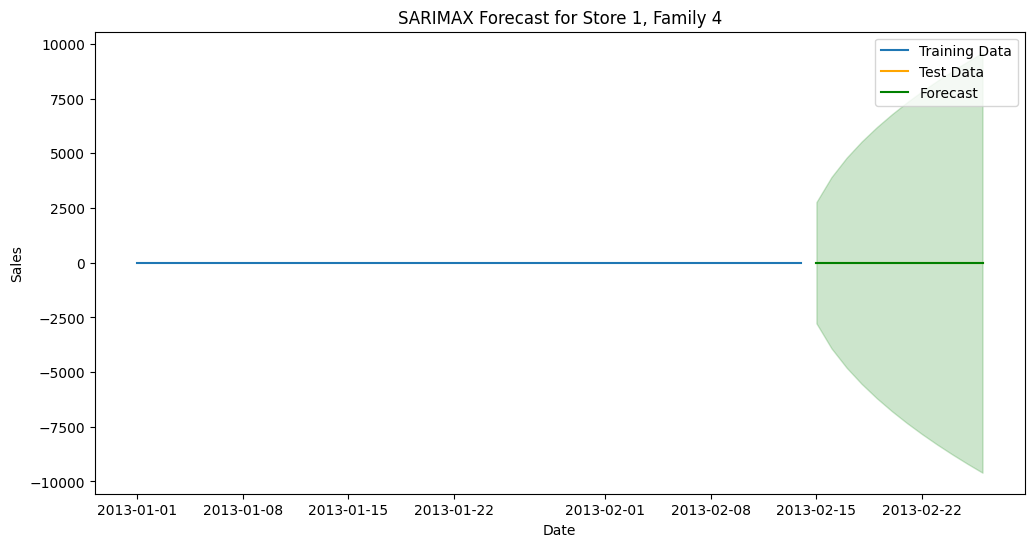

Processing Store 1, Family 5...


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


  Root Mean Squared Logarithmic Error (RMSLE): 0.4067536921803256
Store 1, Family 5:
  Mean Squared Error (MSE): 10090.043367475075
  Mean Absolute Error (MAE): 76.1418325
  Root Mean Squared Error (RMSE): 100.44920789869413
  Root Mean Squared Error (RMSLE): 0.4067536921803256


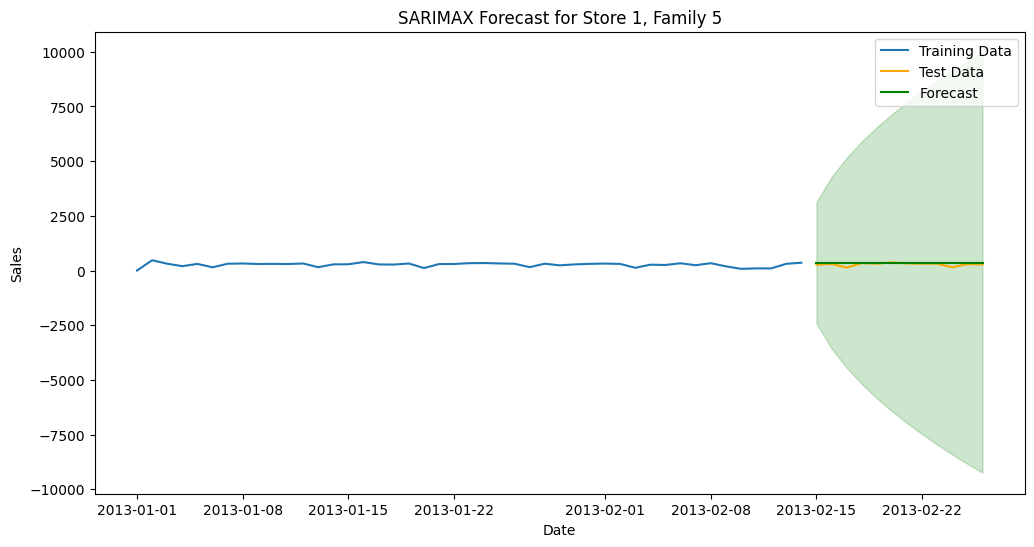

Processing Store 1, Family 6...


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


  Root Mean Squared Logarithmic Error (RMSLE): 0.0
Store 1, Family 6:
  Mean Squared Error (MSE): 0.0
  Mean Absolute Error (MAE): 0.0
  Root Mean Squared Error (RMSE): 0.0
  Root Mean Squared Error (RMSLE): 0.0


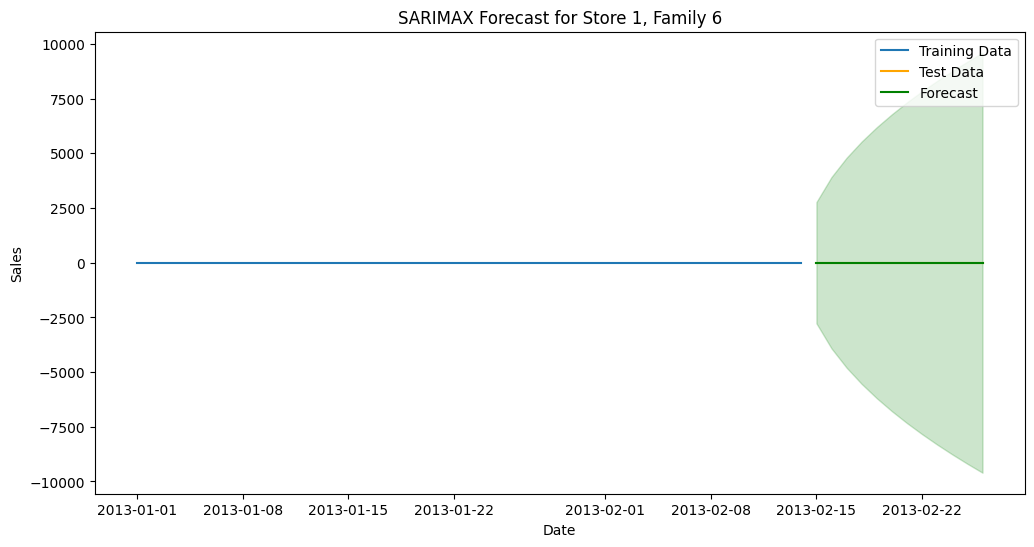

Processing Store 1, Family 7...


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


  Root Mean Squared Logarithmic Error (RMSLE): 0.5358224141451948
Store 1, Family 7:
  Mean Squared Error (MSE): 40516.0
  Mean Absolute Error (MAE): 135.0
  Root Mean Squared Error (RMSE): 201.2858663692014
  Root Mean Squared Error (RMSLE): 0.5358224141451948


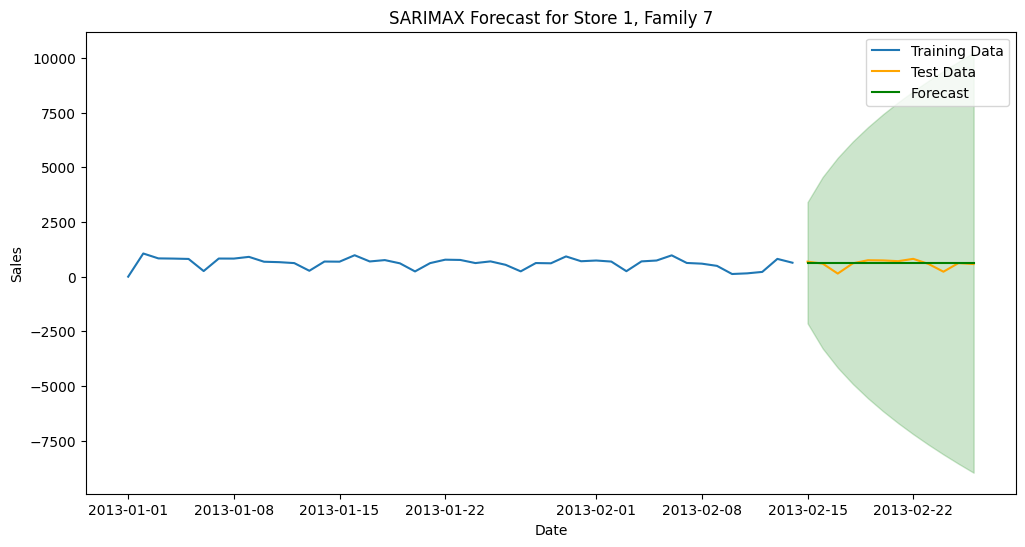

Processing Store 1, Family 8...


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [ ]:
# Import necessary libraries
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Copy data and set the date column as the index
data_copy = data.copy()[:100000]
data_copy.set_index('date', inplace=True)
data_copy.index = pd.to_datetime(data_copy.index)

# Get unique combinations of store and family
store_family_combinations = data_copy[['store_nbr', 'family_encoded']]

# Initialize a dictionary to store results for each (store, family)
results = {}

# Loop through each (store, family) combination
for _, row in store_family_combinations.iterrows():
    store = row['store_nbr']
    family = row['family_encoded']
    print(f"Processing Store {store}, Family {family}...")

    # Filter data for the specific (store, family)
    subset_data = data_copy[(data_copy['store_nbr'] == store) & (data_copy['family_encoded'] == family)]

    # Assign frequency (after filtering for the specific combination)
    subset_data = subset_data.asfreq('D').fillna(0)  # Adjust as needed
    if subset_data.empty:
        print(f"No data available for Store {store}, Family {family}. Skipping...")
        continue
    # print .("subset_data", subset_data.head())

    # Step 2: Train-Test Split
    split_point = int(len(subset_data) * 0.8)
    if split_point == 0:
        print(f"Not enough data for training for Store {store}, Family {family}. Skipping...")
        continue
    train = subset_data.iloc[:split_point]
    test = subset_data.iloc[split_point:]

    # Step 3: Prepare Target and Exogenous Variables
    # Target variable
    sales_series_train = train['sales']
    sales_series_test = test['sales']

    # Exogenous variables (drop target column and irrelevant columns)
    exogenous_features_train = train.drop(columns=['sales', 'id', 'store_nbr', 'family_encoded']).fillna(0)
    exogenous_features_test = test.drop(columns=['sales', 'id', 'store_nbr', 'family_encoded']).fillna(0)

    if exogenous_features_train.empty:
        exogenous_features_train = None
        exogenous_features_test = None


    # Step 4: Define and Fit SARIMAX Model
    order = (1, 1, 1)  # SARIMA order
    seasonal_order = (1, 1, 1, 365)  # Seasonal order with yearly seasonality

    # Initialize SARIMAX model
    model = SARIMAX(sales_series_train,
                    exog=exogenous_features_train,
                    order=order,
                    seasonal_order=seasonal_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False)

    # Fit the model
    sarimax_model = model.fit(disp=False)

    # Step 5: Make Predictions
    forecast = sarimax_model.get_forecast(steps=len(test), exog=exogenous_features_test)
    forecast_mean = forecast.predicted_mean
    forecast_ci = forecast.conf_int()

    # Step 6: Evaluate the Model
    mse = mean_squared_error(sales_series_test, forecast_mean)
    mae = mean_absolute_error(sales_series_test, forecast_mean)
    rmse = np.sqrt(mse)

    y_true = sales_series_test.clip(lower=0)
    y_pred = forecast_mean.clip(lower=0)

    # Calculate RMSLE
    rmsle = np.sqrt(mean_squared_log_error(y_true, y_pred))

    print(f"  Root Mean Squared Logarithmic Error (RMSLE): {rmsle}")

    print(f"Store {store}, Family {family}:")
    print(f"  Mean Squared Error (MSE): {mse}")
    print(f"  Mean Absolute Error (MAE): {mae}")
    print(f"  Root Mean Squared Error (RMSE): {rmse}")
    print(f"  Root Mean Squared Error (RMSLE): {rmsle}")

    # Save results for this combination
    results[(store, family)] = {
        'model': sarimax_model,
        'mse': mse,
        'mae': mae,
        'rmse': rmse,
        'forecast': forecast_mean,
        'test': sales_series_test,
        'forecast_ci': forecast_ci,
        'rmsle': rmsle
    }

    # Step 7: Plot Results for Each (Store, Family)
    plt.figure(figsize=(12, 6))
    plt.plot(train.index, sales_series_train, label='Training Data')
    plt.plot(test.index, sales_series_test, label='Test Data', color='orange')
    plt.plot(test.index, forecast_mean, label='Forecast', color='green')
    plt.fill_between(test.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='green', alpha=0.2)
    plt.title(f'SARIMAX Forecast for Store {store}, Family {family}')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.show()


In [ ]:
import pandas as pd

# Data for the DataFrame
data = {
    "Store": [1, 1, 1, 1, 1, 1, 1, 1],
    "Family": [0, 1, 2, 3, 4, 5, 6, 7],
    "MSE": [4.0, 0.0, 2.4166666666666665, 52267.333333333336, 0.0, 10090.043367475075, 0.0, 40516.0],
    "MAE": [1.5, 0.0, 0.9166666666666666, 208.83333333333334, 0.0, 76.1418325, 0.0, 135.0],
    "RMSE": [2.0, 0.0, 1.5545631755148024, 228.6205006847228, 0.0, 100.44920789869413, 0.0, 201.2858663692014],
    "RMSLE": [0.9453059348728952, 0.0, 0.5516867062154953, 0.36094015109812067, 0.0, 0.4067536921803256, 0.0, 0.5358224141451948]
}

# Create the DataFrame
results_df = pd.DataFrame(data)

# Display the DataFrame
print(results_df)


   Store  Family           MSE         MAE        RMSE     RMSLE
0      1       0      4.000000    1.500000    2.000000  0.945306
1      1       1      0.000000    0.000000    0.000000  0.000000
2      1       2      2.416667    0.916667    1.554563  0.551687
3      1       3  52267.333333  208.833333  228.620501  0.360940
4      1       4      0.000000    0.000000    0.000000  0.000000
5      1       5  10090.043367   76.141833  100.449208  0.406754
6      1       6      0.000000    0.000000    0.000000  0.000000
7      1       7  40516.000000  135.000000  201.285866  0.535822


In [ ]:
import numpy as np

# Calculate Total RMSLE
# Step 1: Compute MSLE for each store-family (RMSLE^2)
results_df['MSLE'] = results_df['RMSLE'] ** 2

# Step 2: Compute the mean MSLE across all rows
mean_msle = results_df['MSLE'].mean()

# Step 3: Calculate the Total RMSLE as the square root of the mean MSLE
total_rmsle = np.sqrt(mean_msle)

# Display the Total RMSLE
print(f"Total RMSLE: {total_rmsle}")


Total RMSLE: 0.4718041901305915


**VARMA**

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

def rmsle_k(y_true, y_pred):
    y_true = np.abs(y_true)
    y_pred = np.abs(y_pred)
    y_true = np.maximum(y_true, 1e-10)
    y_pred = np.maximum(y_pred, 1e-10)
    return np.sqrt(np.mean((np.log1p(y_true) - np.log1p(y_pred)) ** 2))

def preprocess_data(X_train, X_test):
    print("X_train shape:", X_train.shape)
    print("X_test shape:", X_test.shape)

    if not isinstance(X_train, pd.DataFrame):
        X_train = pd.DataFrame(X_train)
    if not isinstance(X_test, pd.DataFrame):
        X_test = pd.DataFrame(X_test)

    X_train.columns = [str(col) for col in X_train.columns]
    X_test.columns = [str(col) for col in X_test.columns]

    common_columns = list(set(X_train.columns) & set(X_test.columns))

    X_train_common = X_train[common_columns]
    X_test_common = X_test[common_columns]

    print("Common features:", common_columns)
    print("X_train_common shape:", X_train_common.shape)
    print("X_test_common shape:", X_test_common.shape)

    return X_train_common.values, X_test_common.values

def predict_with_var(X_train, y_train, X_test, y_test):
    # Preprocess data
    X_train_processed, X_test_processed = preprocess_data(X_train, X_test)

    # Combine features and target variable for training
    y_train_df = pd.DataFrame(y_train)  # Ensure y_train is a DataFrame
    combined_data = pd.DataFrame(X_train_processed, columns=[f'feature_{i}' for i in range(X_train_processed.shape[1])])

    # Assuming y_train is one-dimensional and needs to be added as a new column
    combined_data['target'] = y_train_df.values

    try:
        # Fit VAR model using combined data
        model = sm.tsa.VAR(combined_data)
        results = model.fit(maxlags=100)

        # Forecast
        forecast = results.forecast(combined_data.values[-results.k_ar:], steps=len(X_test_processed))
        print(forecast)
        # Calculate RMSLE
        rmsle = rmsle_k(y_test, forecast[:, -1])  # Assuming last column is target

        print("\nRMSLE:", rmsle)

        # Detailed comparison
        print("\nActual vs Predicted (first 10):")
        for a, p in zip(y_test[:10], forecast[:10, -1]):
            print(f"Actual: {a:.2f}, Predicted: {p:.2f}")

        return forecast[:, -1], rmsle

    except Exception as e:
        print("Prediction Error:", e)
        return None, None

# Example usage (assuming you have defined your datasets):
# # Run prediction
# # Train-test split (keeping temporal order)
# split_index = int(0.8 * len(X))
# X_train, X_val = X[:split_index], X[split_index:]
# y_train, y_val = y[:split_index], y[split_index:]
predictions, rmsle = predict_with_var(X_train, y_train, X_val, y_val)


X_train shape: (431376, 27)
X_test shape: (107845, 27)
Common features: ['26', '9', '12', '14', '11', '7', '4', '5', '24', '15', '18', '19', '0', '22', '16', '21', '17', '6', '10', '20', '1', '23', '8', '3', '2', '25', '13']
X_train_common shape: (431376, 27)
X_test_common shape: (107845, 27)
[[-3.39783071e-01 -1.68023926e+00 -3.37147291e-01 ... -1.12692276e+00
   1.77812602e+00  3.00000000e+00]
 [-3.13810915e-01 -1.57531956e+00 -3.11341238e-01 ...  2.41360147e-01
   1.77805580e+00  7.92168456e-10]
 [-3.27105897e-01 -1.47053511e+00 -2.41256872e-01 ... -1.50803013e+00
   1.77803668e+00  1.00000000e+00]
 ...
 [-2.98227560e-01  1.50642436e+00  5.22373496e-04 ... -9.09820943e-05
   2.30721147e+00  1.56251504e+01]
 [-2.69047517e-01  1.60764454e+00  5.24900665e-04 ... -6.00445812e-04
   2.30721363e+00  3.63938508e+01]
 [-2.92325046e-01 -1.61693900e+00  5.20408041e-04 ...  1.29069170e-04
   2.30741422e+00  1.99166282e+01]]

RMSLE: 2.205918821554213

Actual vs Predicted (first 10):
Actual: 3.0

**VECM**

**PROPHET**

## Machine Learning Models

In [ ]:
def mean_absolute_error(y_actual, y_predicted):
    """
    Calculate the Mean Absolute Error (MAE).
    Args:
        y_actual (list): List of actual values.
        y_predicted (list): List of predicted values.
    Returns:
        float: MAE value.
    """
    mae = sum(abs(y - y_hat) for y, y_hat in zip(y_actual, y_predicted)) / len(y_actual)
    return mae

def root_mean_squared_error(y_actual, y_predicted):
    """
    Calculate the Root Mean Squared Error (RMSE).
    Args:
        y_actual (list): List of actual values.
        y_predicted (list): List of predicted values.
    Returns:
        float: RMSE value.
    """
    rmse = (sum((y - y_hat) ** 2 for y, y_hat in zip(y_actual, y_predicted)) / len(y_actual)) ** 0.5
    return rmse

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)  # Fit and transform the feature matrix

In [ ]:
# Custom scorer for cross-validation
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

# Train-test split (keeping temporal order)
split_index = int(0.8 * len(X))
X_train, X_val = X[:split_index], X[split_index:]
y_train, y_val = y[:split_index], y[split_index:]

In [ ]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score
import numpy as np

# Updated training pipeline function with hyperparameter tuning
def train_pipeline(model, X, y, cv_splits=5, param_grid=None):
    # Time series cross-validation
    tscv = TimeSeriesSplit(n_splits=cv_splits)

    if param_grid:
        # Perform GridSearchCV instead of RandomizedSearchCV
        search = GridSearchCV(
            estimator=model,
            param_grid=param_grid,  # Use param_grid instead of param_distributions
            scoring=rmsle_scorer,  # Assuming rmsle_scorer is predefined
            cv=tscv,
            verbose=1,
            n_jobs=-1,
            return_train_score=True  # Optional: to get training scores along with test scores
        )
        # Fit the search
        search.fit(X, y)
        best_model = search.best_estimator_
        print(f"Best hyperparameters: {search.best_params_}")
        print(f"Best RMSLE Score: {-search.best_score_:.4f}")
    else:
        # No hyperparameter tuning, just cross-validate and fit the base model
        scores = cross_val_score(model, X, y, cv=tscv, scoring=rmsle_scorer)
        print(f"Cross-validated RMSLE: {-scores.mean():.4f} ± {scores.std():.4f}")
        best_model = model
        best_model.fit(X, y)

    return best_model


In [ ]:
def evaluate_model(name, model):
  # print(f"\nTraining {name} model")
  # trained_model = train_pipeline(model, X_train, y_train)

  # Validation prediction
  y_pred = model.predict(X_val)

  # Shift to avoid negative values for RMSLE
  min_value = min(np.min(y_val), np.min(y_pred))
  shift = abs(min_value) + 1
  y_pred_shifted = y_pred + shift
  y_val_shifted = y_val + shift

  # Evaluation
  val_rmsle = rmsle(y_val_shifted, y_pred_shifted)
  val_rmse = root_mean_squared_error(y_val, y_pred)
  val_mae = mean_absolute_error(y_val, y_pred)
  print(f"Validation RMSLE for {name}: {val_rmsle:.4f}")
  print(f"Validation RMSE for {name}: {val_rmse:.4f}")
  print(f"Validation MAE for {name}: {val_mae:.4f}")

###Linear Regression

In [ ]:
linear_model = LinearRegression()
trained_linear_model = train_pipeline(linear_model, X_train, y_train)
evaluate_model('Linear Regression', trained_linear_model)

Cross-validated RMSLE: 0.7847 ± 1.3806
Validation RMSLE for Linear Regression: 0.0793
Validation RMSE for Linear Regression: 353.7374
Validation MAE for Linear Regression: 112.5334


### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    'n_estimators': [100],
    'max_depth': [5],
    'min_samples_split': [5],
    'min_samples_leaf': [ 2]
}
# Initialize the base model
rf_model = RandomForestRegressor(random_state=42)

trained_rf_model = train_pipeline(
    model=rf_model,
    param_grid=param_grid,
    X=X_train,
    y=y_train,
)

evaluate_model('RandomForestRegressor', trained_rf_model)

### LightGBM

In [ ]:
param_grid = {
    'n_estimators': [100],
    'learning_rate': [0.1],
    'max_depth': [5]
}
# Initialize the base model
lgb_model = lgb.LGBMRegressor()

trained_lgb_model = train_pipeline(
    model=lgb_model,
    param_grid=param_grid,
    X=X_train,
    y=y_train,
)

evaluate_model('LGBMRegressor', trained_lgb_model)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.255957 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4736
[LightGBM] [Info] Number of data points in the train set: 2401106, number of used features: 27
[LightGBM] [Info] Start training from score 328.215038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

### SVM

In [ ]:
from sklearn.svm import SVR
# Grid search for hyperparameter tuning
param_grid = {'C': [0.1], 'epsilon': [0.01], 'gamma': ['auto']}


# Define the SVM model
svm = SVR(kernel='rbf')  # You can experiment with other kernels like 'linear' or 'poly'

trained_svm_model = train_pipeline(
    model=svm,
    param_grid=param_grid,
    X=X_train,
    y=y_train
)

evaluate_model('SVM', trained_svm_model)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


KeyboardInterrupt: 

### XGBoost

In [ ]:
param_grid = {
    'n_estimators': [100],
    'learning_rate': [ 0.5],
    'max_depth': [5],
    'colsample_bytree': [1.0],
    'subsample': [1.0]
}
# Initialize the base model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

trained_model = train_pipeline(
    model=xgb_model,
    X=X_train,
    y=y_train,
    param_grid=param_grid
)


evaluate_model('XGBRegressor', trained_model)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}
Best RMSLE Score: 0.0605
Validation RMSLE for XGBRegressor: 0.0285
Validation RMSE for XGBRegressor: 217.1455
Validation MAE for XGBRegressor: 43.6438


## Deep Learning Models

###LSTM

In [ ]:
# Function to create sequences
def create_sequences(data, target, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps, :])
        y.append(target[i+time_steps])
    return np.array(X), np.array(y)

time_steps = 30  # Number of past days to consider
y = scaler.fit_transform(y.values.reshape(-1, 1))  # Scale target
X_seq, y_seq = create_sequences(X, y, time_steps)

In [ ]:
split = int(0.8 * len(X_seq))  # 80% for training
X_train, X_val = X_seq[:split], X_seq[split:]
y_train, y_val = y_seq[:split], y_seq[split:]

### RNN

In [ ]:
!pip install scikeras


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV

device_name = '/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'
print(f"Using device: {device_name}")

split_index = int(0.8 * len(X))
X_train, X_val = X[:split_index], X[split_index:]
y_train, y_val = y[:split_index], y[split_index:]

# X_train_scaled, X_val_scaled, y_train_scaled, y_val_scaled, scaler_X, scaler_y = split_scale_data(X, y)

X_train_rnn = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val_rnn = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

# # Use scaled y_train_scaled and y_val_scaled as they are
y_train_rnn = y_train
y_val_rnn = y_val


# Define function to create model with hyperparameters
def create_model(units=50, activation='relu', optimizer='adam'):
    model = tf.keras.Sequential([
        tf.keras.layers.SimpleRNN(units, activation=activation, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Wrap Keras model for GridSearchCV
model_rnn = KerasRegressor(build_fn=create_model, verbose=0)

# Define hyperparameter grid
param_grid = {
    'model__units': [50],  # Number of RNN units
    'model__activation': ['relu'],  # Activation functions
    'optimizer': ['adam'],  # Optimizers
    'batch_size': [32],  # Batch sizes
    'epochs': [10]  # Number of epochs
}


# Initialize GridSearchCV
grid = GridSearchCV(estimator=model_rnn, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)

# Fit GridSearchCV
grid_result = grid.fit(X_train_rnn, y_train_rnn)

# Print the best parameters and score
print("Best parameters found: ", grid_result.best_params_)
print("Best score found: ", -grid_result.best_score_)

# Use the best model to make predictions
best_model = grid_result.best_estimator_
y_pred_val = best_model.predict(X_val_rnn)


model_rnn.fit(X_train_rnn, y_train_rnn, epochs=20, batch_size=32, validation_data=(X_val_rnn, y_val_rnn), verbose=1)
y_pred_val = model_rnn.predict(X_val_rnn)


Using device: /GPU:0
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in 

Best parameters found:  {'batch_size': 32, 'epochs': 10, 'model__activation': 'relu', 'model__units': 50, 'optimizer': 'adam'}
Best score found:  34071.61253869639


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
75035/75035 ━━━━━━━━━━━━━━━━━━━━ 109s 1ms/step - loss: 188804.9844 - val_loss: 79614.2344
Epoch 2/20
75035/75035 ━━━━━━━━━━━━━━━━━━━━ 107s 1ms/step - loss: 56962.8047 - val_loss: 65213.3906
Epoch 3/20
75035/75035 ━━━━━━━━━━━━━━━━━━━━ 106s 1ms/step - loss: 51222.9492 - val_loss: 56297.7656
Epoch 4/20
75035/75035 ━━━━━━━━━━━━━━━━━━━━ 106s 1ms/step - loss: 56473.7422 - val_loss: 49217.0469
Epoch 5/20
75035/75035 ━━━━━━━━━━━━━━━━━━━━ 107s 1ms/step - loss: 35332.5078 - val_loss: 46951.0664
Epoch 6/20
75035/75035 ━━━━━━━━━━━━━━━━━━━━ 106s 1ms/step - loss: 30319.2480 - val_loss: 43217.9023
Epoch 7/20
75035/75035 ━━━━━━━━━━━━━━━━━━━━ 105s 1ms/step - loss: 30609.8594 - val_loss: 42195.6719
Epoch 8/20
75035/75035 ━━━━━━━━━━━━━━━━━━━━ 106s 1ms/step - loss: 33319.1602 - val_loss: 40357.4375
Epoch 9/20
75035/75035 ━━━━━━━━━━━━━━━━━━━━ 106s 1ms/step - loss: 29622.3340 - val_loss: 40308.4727
Epoch 10/20
75035/75035 ━━━━━━━━━━━━━━━━━━━━ 105s 1ms/step - loss: 34789.4180 - val_loss: 41248.414

In [ ]:
val_rmsle = rmsle(y_val_rnn, y_pred_val)
val_rmse = root_mean_squared_error(y_val_rnn, y_pred_val)
val_mae = mean_absolute_error(y_val_rnn, y_pred_val)
print(f"Validation RMSLE for RNN: {val_rmsle:.4f}")
print(f"Validation RMSE for RNN: {val_rmse:.4f}")
print(f"Validation MAE for RNN: {val_mae:.4f}")

Validation RMSLE for RNN: 0.1300
Validation RMSE for RNN: 195.8366
Validation MAE for RNN: 59.5668


###Transformer

In [ ]:
!pip install keras-tuner

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, MultiHeadAttention, LayerNormalization, Dropout, Concatenate, GlobalAveragePooling1D
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Example data (replace with your actual data)
data_size = len(data)
time_steps = 28

# Separate temporal, static, and target features
temporal_features = [
    "lag_7", "lag_14", "lag_1", "lag_28", "onpromotion", "trend_28", "trend_7",
    "transactions", "trend_365", "oil", "oil_lag_1", "oil_lag_7", "oil_lag_14",
   "dayofweek",
]

# KeyError: "['is_weekend', 'is_national_holiday', 'month', 'quarter'] not in index"


static_features = [
    "family_encoded", "store_type_encoded",
    "city_encoded", "store_nbr", "cluster", "year"
]

# Calculate the correct number of rows to match time steps
num_samples = len(data) // time_steps  # Total samples to use
adjusted_size = num_samples * time_steps

# Truncate the data to fit the reshape requirements
data_copy = data.iloc[:adjusted_size].fillna(method='bfill').fillna(method='ffill')

# Prepare temporal, static, and target data
X_temporal = data_copy[temporal_features].values.reshape(num_samples, time_steps, len(temporal_features))
X_static = data_copy[static_features].iloc[::time_steps].values  # Static features remain 2D
y = data_copy["sales"].iloc[::time_steps].values  # Target variable matches static feature alignment




# Split data into training and validation sets
X_train_temporal, X_val_temporal, X_train_static, X_val_static, y_train, y_val = train_test_split(
    X_temporal, X_static, y, test_size=0.2, random_state=42
)


import tensorflow as tf

def rmsle_temporal(y_true, y_pred):
    # Convert to float32 for consistency
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # Compute the shift based on the minimum value
    min_value = tf.minimum(tf.reduce_min(y_true), tf.reduce_min(y_pred))
    shift = tf.abs(min_value) + 1

    # Shift the values to make them non-negative
    y_true_shifted = y_true + shift
    y_pred_shifted = y_pred + shift

    # Compute the logarithm
    log_true = tf.math.log1p(y_true_shifted)
    log_pred = tf.math.log1p(y_pred_shifted)

    # Compute Mean Squared Logarithmic Error (MSLE)
    msle = tf.reduce_mean(tf.square(log_true - log_pred))

    # Compute RMSLE
    rmsle = tf.sqrt(msle)

    return rmsle


<ipython-input-12-df3811857930>:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_copy = data.iloc[:adjusted_size].fillna(method='bfill').fillna(method='ffill')


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, MultiHeadAttention, LayerNormalization, Dropout, Concatenate, GlobalAveragePooling1D
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch

def build_tft_model(hp):
    # Define hyperparameters
    num_heads = hp.Choice('num_heads', values=[2, 4, 6, 8])
    dense_units = hp.Choice('dense_units', values=[32, 64, 128])
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    static_dense_units = hp.Choice('static_dense_units', values=[10, 20, 30])

    # Temporal input
    temporal_input = Input(shape=(time_steps, len(temporal_features)), name="temporal_input")
    static_input = Input(shape=(len(static_features),), name="static_input")

    # Attention mechanism
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=len(temporal_features))(temporal_input, temporal_input)
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output + temporal_input)
    attention_output = Dropout(dropout_rate)(attention_output)

    # Fully connected layers
    dense_output = Dense(dense_units, activation='relu')(attention_output)
    dense_output = Dense(1)(dense_output)

    # Aggregate temporal dimensions
    aggregated_output = GlobalAveragePooling1D()(dense_output)

    # Combine with static features
    static_dense = Dense(static_dense_units, activation="relu")(static_input)
    combined = Concatenate()([aggregated_output, static_dense])
    output = Dense(1)(combined)

    model = Model(inputs=[temporal_input, static_input], outputs=output)

    # Compile the model with the custom loss
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=rmsle_temporal,
        metrics=['mae', rmsle_temporal]
    )

    return model

# Set up KerasTuner
tuner = RandomSearch(
    build_tft_model,
    objective='val_loss',
    max_trials=10,  # Number of hyperparameter combinations to try
    executions_per_trial=1,  # Number of models to train per combination
    directory='tft_hyperparameter_tuning',
    project_name='tft_tuning'
)

# Search for the best hyperparameters
tuner.search(
    [X_train_temporal, X_train_static],
    y_train,
    validation_data=([X_val_temporal, X_val_static], y_val),
    epochs=10,
    batch_size=32,
    verbose=1
)

# Get the best hyperparameters and build the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
print(f"num_heads: {best_hps.get('num_heads')}")
print(f"dense_units: {best_hps.get('dense_units')}")
print(f"dropout_rate: {best_hps.get('dropout_rate')}")
print(f"static_dense_units: {best_hps.get('static_dense_units')}")

# Train the best model
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    [X_train_temporal, X_train_static],
    y_train,
    validation_data=([X_val_temporal, X_val_static], y_val),
    epochs=20,
    batch_size=32,
    verbose=1
)


Trial 10 Complete [00h 01m 27s]
val_loss: 1.1996142864227295

Best val_loss So Far: 1.1855005025863647
Total elapsed time: 00h 14m 24s
Best Hyperparameters:
num_heads: 2
dense_units: 64
dropout_rate: 0.1
static_dense_units: 20
Epoch 1/20
2680/2680 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 1.9099 - mae: 415.7404 - rmsle_temporal: 1.9756 - val_loss: 1.2120 - val_mae: 404.4037 - val_rmsle_temporal: 1.2883
Epoch 2/20
2680/2680 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 1.2156 - mae: 415.8988 - rmsle_temporal: 1.2899 - val_loss: 1.2185 - val_mae: 422.9047 - val_rmsle_temporal: 1.2898
Epoch 3/20
2680/2680 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 1.2023 - mae: 421.3107 - rmsle_temporal: 1.2719 - val_loss: 1.2970 - val_mae: 487.1557 - val_rmsle_temporal: 1.3458
Epoch 4/20
2680/2680 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 1.2091 - mae: 416.8836 - rmsle_temporal: 1.2697 - val_loss: 1.2229 - val_mae: 419.6239 - val_rmsle_temporal: 1.2842
Epoch 5/20
2680/2680 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss

In [ ]:
y_pred_val = best_model.predict( [X_val_temporal, X_val_static])

val_rmsle = rmsle_temporal(y_val, y_pred_val)
print("RMSLE for TFT", val_rmsle)

670/670 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
RMSLE for TFT tf.Tensor(0.49742875, shape=(), dtype=float32)


###TCN

###DeepAR

###NBeats


IndexError: list index out of range

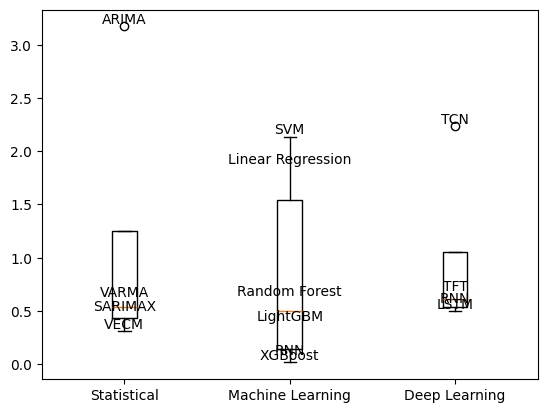

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have your RMSLE values in a list for each model
statistical_rmsle = [3.1719, 0.4718, 0.3088, 0.6101]
machine_learning_rmsle = [1.8545, 0.6182, 2.1368, 0.0163, 0.3804, 0.0592]
deep_learning_rmsle = [0.5543, 0.497, 0.66245, 2.2333]

# Model names for each type
statistical_models = ['ARIMA', 'SARIMAX', 'VECM', 'VARMA']  # Reduced to 4 models
machine_learning_models = ['Linear Regression', 'Random Forest', 'SVM', 'XGBoost', 'LightGBM', 'RNN']
deep_learning_models = ['RNN', 'LSTM', 'TFT', 'TCN', 'N-beats']

# Create a figure and axis
fig, ax = plt.subplots()

# Create box plots for each model type with individual model names
ax.boxplot(statistical_rmsle, positions=[1], labels=['Statistical'])
ax.boxplot(machine_learning_rmsle, positions=[2], labels=['Machine Learning'])
ax.boxplot(deep_learning_rmsle, positions=[3], labels=['Deep Learning'])

# Add individual model names as labels
for i, model in enumerate(statistical_models):
    ax.text(1, statistical_rmsle[i], model, ha='center', va='bottom')

for i, model in enumerate(machine_learning_models):
    ax.text(2, machine_learning_rmsle[i], model, ha='center', va='bottom')

for i, model in enumerate(deep_learning_models):
    ax.text(3, deep_learning_rmsle[i], model, ha='center', va='bottom')

# Set y-axis label and title
ax.set_ylabel('RMSLE')
ax.set_title('RMSLE Comparison by Model Type')

plt.show()

# THE FOLLOWING CODE IS NOT FINAL, ONLY FOR TESTING

### ARIMA

In [ ]:
# Ensure date is the index and sorted
train['date'] = pd.to_datetime(train['date'])
train.set_index('date', inplace=True)
train.sort_index(inplace=True)

# Define sales series for ARIMA modeling
sales_series = train['sales']

# Train-test split (e.g., last 10% as test data)
split_ratio = 0.9
split_index = int(len(sales_series) * split_ratio)
train_series, test_series = sales_series[:split_index], sales_series[split_index:]

# Fit ARIMA model (adjust p, d, q based on ACF/PACF or experimentation)
arima_model = ARIMA(train_series, order=(1, 1, 1))  # Start with (1, 1, 1) and tune if needed
arima_result = arima_model.fit()

# Forecast on test set length
forecast = arima_result.forecast(steps=len(test_series))

# Shift predictions and true values for RMSLE calculation
shift = 1 - min(min(forecast), min(test_series))
forecast_shifted = forecast + shift
test_series_shifted = test_series + shift
rmsle = np.sqrt(mean_squared_log_error(test_series_shifted, forecast_shifted))

# Print RMSLE
print(f"ARIMA RMSLE: {rmsle:.4f}")

# Plot the forecast vs actuals
plt.figure(figsize=(10, 5))
plt.plot(train_series, label='Training Data')
plt.plot(test_series, label='Test Data')
plt.plot(test_series.index, forecast, label='ARIMA Forecast', color='orange')
plt.title("ARIMA Sales Forecast vs Actual Sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()


## PROPHET

In [ ]:
store_25 = train[train['store_nbr'] == 25]
store_25_family_0 = store_25[store_25['family_encoded'] == 0]

store_25_family_0 = store_25_family_0.drop(columns=[col for col in store_25_family_0.columns if col.startswith('lag_') or col.startswith('rolling_mean')])

store_25_family_0 = store_25_family_0.sort_values(by='date')
store_25_family_0 = store_25_family_0.reset_index()

store_25_family_0 = store_25_family_0.drop_duplicates(subset='date', keep='first')

In [ ]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Copy your DataFrame
df = store_25_family_0.copy()

# Prepare the DataFrame for Prophet
prophet_df = df[['date', 'sales']].rename(columns={'date': 'ds', 'sales': 'y'})
# Ensure 'ds' is of datetime type
prophet_df['ds'] = pd.to_datetime(prophet_df['ds'])

# Add regressors
prophet_df['oil'] = df['oil'].values
prophet_df['is_weekend'] = df['is_weekend'].values
prophet_df['transactions'] = df['transactions'].values
# Sort the DataFrame by date
prophet_df = prophet_df.sort_values('ds')

# Train-test split
split_ratio = 0.9
split_index = int(len(prophet_df) * split_ratio)
train_prophet = prophet_df[:split_index]
test_prophet = prophet_df[split_index:]

# Initialize the Prophet model
model = Prophet()
model.add_regressor('oil')
# model.add_regressor('dayofweek')
model.add_regressor('is_weekend')
model.add_regressor('transactions')

# Fit the model
model.fit(train_prophet)



In [ ]:
# Create future DataFrame
future = model.make_future_dataframe(periods=len(test_prophet), freq='D')

# Merge the regressor data into the future DataFrame
future = future.merge(prophet_df[['ds', 'oil', 'is_weekend', 'transactions']], on='ds', how='left')

# Generate forecast
forecast = model.predict(future)

# Extract the forecasted values for the test period
forecast_test = forecast[['ds', 'yhat']].set_index('ds').loc[test_prophet['ds']]

# Actual values
actual_test = test_prophet.set_index('ds')['y']

# Calculate evaluation metrics
mse = mean_squared_error(actual_test, forecast_test['yhat'])
mae = mean_absolute_error(actual_test, forecast_test['yhat'])
rmse = np.sqrt(mse)

print(f'Prophet RMSE: {rmse:.2f}')
print(f'Prophet MAE: {mae:.2f}')

In [ ]:
# Plot the forecast vs actuals
plt.figure(figsize=(14, 7))
plt.plot(train_prophet['ds'], train_prophet['y'], label='Training Data')
plt.plot(actual_test.index, actual_test, label='Test Data')
plt.plot(forecast_test.index, forecast_test['yhat'], label='Prophet Forecast', color='green')
plt.title('Prophet Sales Forecast vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

# Plot forecast components
model.plot_components(forecast)
plt.show()

### RANDOM FOREST

In [ ]:
# Your DataFrame is called 'train_df'
# Define features and target
features = [
    'store_nbr', 'family_encoded', 'onpromotion', 'cluster', 'oil',
    'is_national_holiday', 'is_regional_holiday', 'is_local_holiday',
    'transactions', 'year', 'month', 'day', 'dayofweek', 'weekofyear',
    'quarter', 'is_weekend', 'lag_1', 'lag_7', 'lag_14', 'lag_28',
    'rolling_mean_7', 'rolling_mean_14', 'rolling_mean_28',
    'city_encoded', 'state_encoded', 'store_type_encoded'
]
target = 'sales'

# Split data into features (X) and target (y)
X = train[features]
y = train[target]

# Split into training and validation sets (e.g., 80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False  # shuffle=False for time series
)


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Initialize RandomForestRegressor
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)


In [ ]:
def train_pipeline(model, X_train, y_train, X_val, y_val):
    """
    Train the model and evaluate on validation data.
    """
    # Fit the model
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    return model


In [ ]:
# Update the models dictionary
models = {
    'RandomForest': rf_model,
}


In [ ]:
# Function to calculate RMSLE
def rmsle(y_true, y_pred):
    # Ensure no negative values
    y_true = np.maximum(0, y_true)
    y_pred = np.maximum(0, y_pred)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

# Training and evaluation loop
for name, model in models.items():
    print(f"\nTraining {name} model")

    if name == 'RandomForest':
        # RandomForest does not support eval_set
        model.fit(X_train, y_train)
    else:
        # For models that support eval_set
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    # Validation prediction
    y_pred = model.predict(X_val)

    # Ensure predictions are non-negative
    y_pred = np.maximum(0, y_pred)

    # Evaluation
    val_rmsle = rmsle(y_val, y_pred)
    print(f"Validation RMSLE for {name}: {val_rmsle:.4f}")

    # Feature importance plot (for models that support it)
    if hasattr(model, 'feature_importances_'):
        plt.figure(figsize=(10, 6))
        importance = model.feature_importances_
        indices = np.argsort(importance)
        plt.barh(range(len(indices)), importance[indices], align='center')
        plt.yticks(range(len(indices)), [features[i] for i in indices])
        plt.title(f"{name} Feature Importance")
        plt.xlabel('Relative Importance')
        plt.show()


# Feature selection

In [ ]:


# Assuming 'train' is your DataFrame
# Exclude non-feature columns
exclude_cols = ['date', 'id', 'sales']
features = [col for col in train.columns if col not in exclude_cols]

# Calculate the correlation matrix
corr_matrix = train[features + ['sales']].corr()

# Plot the correlation matrix
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [ ]:
# Get absolute correlations with 'sales'
corr_with_target = corr_matrix['sales'].abs().sort_values(ascending=False)

# Remove 'sales' from the list (correlation of 'sales' with itself is 1.0)
corr_with_target = corr_with_target.drop('sales')

# Display the correlations
print("Correlation of features with 'sales':\n")
print(corr_with_target)


In [ ]:
N = 15
top_features = corr_with_target.index[:N].tolist()

print(f"\nTop {N} features most correlated with 'sales':")
print(top_features)


In [ ]:
# Custom scorer for cross-validation
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

# Load your data here (assuming `train` DataFrame is already available)
features = [col for col in train.columns if col not in ['id', 'date', 'sales']]
X = train[features]
y = train['sales']

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

# Define a training pipeline function
def train_pipeline(model, X, y, cv_splits=5):
    # Cross-validation setup
    kf = KFold(n_splits=cv_splits, shuffle=True, random_state=42)

    # Cross-validation scoring
    scores = cross_val_score(model, X, y, cv=kf, scoring=rmsle_scorer)
    print(f"Cross-validated RMSLE: {-scores.mean():.4f} ± {scores.std():.4f}")

    # Fit the model on the entire dataset
    model.fit(X, y)
    return model

In [ ]:
import xgboost as xgb

# Define models for experimentation
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)
lgb_model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)


In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)


In [ ]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Create a pipeline for SVM with scaling
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVR())
])


In [ ]:
models = {'XGBoost': xgb_model, 'LightGBM': lgb_model}
for name, model in models.items():
    print(f"\nTraining {name} model")
    trained_model = train_pipeline(model, X_train, y_train)

    # Validation prediction
    y_pred = trained_model.predict(X_val)

    # Shift to avoid negative values for RMSLE
    min_value = min(np.min(y_val), np.min(y_pred))
    shift = abs(min_value) + 1
    y_pred_shifted = y_pred + shift
    y_val_shifted = y_val + shift

    # Evaluation
    val_rmsle = rmsle(y_val_shifted, y_pred_shifted)
    print(f"Validation RMSLE for {name}: {val_rmsle:.4f}")

    # Feature importance plot (for models that support it)
    if hasattr(trained_model, 'feature_importances_'):
        plt.figure(figsize=(10, 6))
        plt.barh(X.columns, trained_model.feature_importances_)
        plt.title(f"{name} Feature Importance")
        plt.show()

In [ ]:
# Get absolute correlations with 'sales'
corr_with_target = corr_matrix['sales'].abs().sort_values(ascending=False)

# Remove 'sales' from the list
corr_with_target = corr_with_target.drop('sales')

# Display the correlations
print("Correlation of features with 'sales':\n")
print(corr_with_target)


In [ ]:
from sklearn.model_selection import train_test_split

# Define the target variable
target = 'sales'

# Prepare your data
X_full = train[features]
y_full = train[target]

# Split into training and validation sets (ensure temporal order)
X_train_full, X_val_full, y_train_full, y_val_full = train_test_split(
    X_full, y_full, test_size=0.2, shuffle=False
)


In [ ]:
n_features_list = []
rmsle_xgb_list = []
rmsle_lgb_list = []


In [ ]:
import xgboost as xgb
import lightgbm as lgb

# Define the maximum number of features to consider
max_features = len(corr_with_target)

# Loop over different numbers of top features
for N in range(1, max_features + 1):
    top_N_features = corr_with_target.index[:N].tolist()

    print(f"\nEvaluating models with top {N} features:")
    print(top_N_features)

    # Prepare data with top N features
    X_train = X_train_full[top_N_features]
    X_val = X_val_full[top_N_features]
    y_train = y_train_full
    y_val = y_val_full

    # Define models
    xgb_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    )

    lgb_model = lgb.LGBMRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    )

    models = {'XGBoost': xgb_model, 'LightGBM': lgb_model}

    rmsle_results = {}

    for name, model in models.items():
        # Train the model
        model.fit(X_train, y_train)

        # Predict on validation set
        y_pred = model.predict(X_val)

        # Ensure predictions are non-negative
        y_pred = np.maximum(0, y_pred)

        # Calculate RMSLE
        val_rmsle = rmsle(y_val, y_pred)
        rmsle_results[name] = val_rmsle
        print(f"{name} Validation RMSLE with top {N} features: {val_rmsle:.4f}")

    # Record the results
    n_features_list.append(N)
    rmsle_xgb_list.append(rmsle_results['XGBoost'])
    rmsle_lgb_list.append(rmsle_results['LightGBM'])


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(n_features_list, rmsle_xgb_list, marker='o', label='XGBoost')
plt.plot(n_features_list, rmsle_lgb_list, marker='o', label='LightGBM')
plt.title('Validation RMSLE vs Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('Validation RMSLE')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
from darts import TimeSeries
from darts.models import NBEATSModel
from darts.metrics import mape
from sklearn.metrics import mean_squared_log_error
import numpy as np

# Load the time series dataset
data = pd.read_csv(base_path+"final_data.csv")

# Extract the target column 'sales' as the time series
# Ensure the data is in the correct format (sequential index)
time_series = TimeSeries.from_dataframe(data, value_cols='sales')

# Split the dataset into train and test sets
split_index = int(len(time_series) * 0.8)
train_series = time_series[:split_index]
test_series = time_series[split_index:]

# Initialize the N-BEATS model
model = NBEATSModel(
    input_chunk_length=30,  # Number of past observations to use for predictions
    output_chunk_length=7,  # Forecast horizon (e.g., 7 days)
    random_state=42
)

# Fit the model on the training data
model.fit(train_series, epochs=50, verbose=True)

# Make predictions
forecast = model.predict(n=7)  # Forecast for the next 7 days

# Evaluate the model
# MAPE
error_mape = mape(test_series, forecast)
print(f"Mean Absolute Percentage Error (MAPE): {error_mape:.2f}%")

# RMSLE
true_values = test_series.values()
predicted_values = forecast.values()
error_rmsle = np.sqrt(mean_squared_log_error(true_values, predicted_values))
print(f"Root Mean Squared Logarithmic Error (RMSLE): {error_rmsle:.4f}")

# Plot the results
time_series.plot(label="Actual")
forecast.plot(label="Forecast")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.2 M  | train
-------------------------------------------------------------
6.2 M     Trainable params
1.5 K     Non-trainable params
6.2 M     Total params
24.972    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]